# Week 5 - Semantic & Influence Networks

This week, we explore the representation and analysis of semantic and influence networks. We begin by introducing you to some straightforward approaches to network analysis. We then begin to illustrate them with word networks that we can analyze to understand the structure of how words connect with one another, and the dynamics of how their meanings flow through a discursive system. For example, we can define links between words as a function of their co-presence within a document, chapter, paragraph, sentence, noun phrase or continuous bag of words. We can also define links as a function of words that rely on one another within a directed dependency parse, or links between extracted Subjects, Verbs and Objects, or nouns and the adjectives that modify them (or verbs and the adverbs that modify them). Rendering words linked as a network or discrete topology allows us to take advantage of the network analysis metrics like centrality and community.

Texts also represent moves in a social game, and we can analyze the interchange of words and phrases within them in order to understand more about the relationships between people, groups and organizations that interact with one another. For example, who influences whom? And in a singular conversation--like a discussion of tweets on comments in Facebook--or over vast stretches of time (e.g., How much was Kant influenced by Aristotle? by Plato? Was _Chinatown_ director Robert Towne influenced by Sophocles?) We will do this by extracting conversational moves from text. But note that the similarity measures from last week's homework can also be used to represent a matrix of similarities--and potential influences--from one document to another. Rendering social actors or documentary events (e.g., a book) linked as a network or discrete topology allows us to take advantage of the wide range of metrics and models developed for network analysis. These include measurement of network centrality, density and modularity, "block modeling" structurally equivalent relationships, and sophisticated graphical renderings of networks or network partitions that allow us to visually interrogate their structure and complexity of social relations. Moreover, we can link explicit social interactions (e.g., "friendship" on Facebook, coupling in a romantic relationship, etc.) with semantic networks to better make sense of how pepole (inter)act in the world. 

For this notebook we will use the following packages:

In [9]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import sklearn #For generating some matrices
import pandas as pd #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os

%matplotlib inline

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that render networks to meaningfully characterize the structure of words and documents (or subdocuments like chapters or paragraphs) from your corpus. What are useful filters and thresholds and what semantic structures do they reveal that give insight into the social world and social game inscribed in your corpus? Interrogate interesting subgraphs of your network and detail what they reveal about the semantic space involved.

# An Introduction to networks in *networkx*

We will primarily be dealing with graphs in this notebook, so lets first go over how to use them.

To start with lets create an undirected graph:

In [17]:
g = nx.Graph()
g

We can add nodes. These are all named, like entries in a dictionary.

In [18]:
g.add_node(1)
g.add_node(2)
g.add_node(3)

Now we have 3 vertices:

In [19]:
len(g.nodes)

3

Or if we want to get more information about the graph:

In [20]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 3
Number of edges: 0
Average degree:   0.0000


We can give nodes properties, like name or type

In [21]:
g.nodes[1]

{}

In [22]:
g.nodes[1]['type'] = 'NN'

In [23]:
g.nodes[1]

{'type': 'NN'}

In [24]:
g.nodes[2]['name'] = 'dog'

In [25]:
g.nodes[2]

{'name': 'dog'}

Still pretty boring...

Lets add a couple of edges. Notice that we use the ids, but not any of the properties:

In [26]:
g.add_edges_from([(1, 2), (2, 3), (3, 1), (1,4)])
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 4
Number of edges: 4
Average degree:   2.0000


Note how the summary has changed. Moreover, there's one additional node, because we asked for an edge to 4.

We can also give the edges properties like weights:

In [27]:
g.edges[1, 2]['weight'] = 2
g.edges[1, 4]['weight'] = 2
g.edges[1, 4]

{'weight': 2}

Let's visualize our graph now:

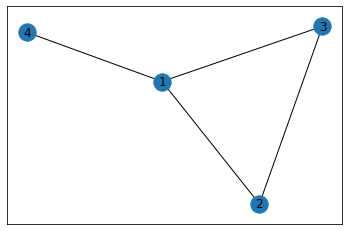

In [28]:
nx.draw_networkx(g)
plt.savefig("test.png")

Very exciting :-).

There are many things to do with the graph once we have created it, some of which we will explore here with a word semantic network.

First let's load some data: 

In [29]:
### UPDATING Corpus1a.csv FILE AND DATAFRAME ###

#concattenating the csv files in the corpus
import glob
path = r'C:\Users\acmel\OneDrive - The University of Chicago\SOCI 40133\SOCI_FINAL\Corpus1a'
all_files = glob.iglob(os.path.join(path, "*.csv")) 
df = pd.concat((pd.read_csv(f).assign(filename = f.replace(path+'\\', "")) for f in all_files), ignore_index=True).drop_duplicates(keep='last')

#removing the $ signs from the Reward column
df['Reward'] = df['Reward'].map(lambda x: x.lstrip(r'd\$'))

#saving the corpus csv 
df.to_csv(r'C:\Users\acmel\OneDrive - The University of Chicago\SOCI 40133\SOCI_FINAL\Corpus1a.csv', index = False)
df

Requester  \
0                    Yixin Nie   
1            Sharmishtha Gupta   
2                        Panel   
3                        Panel   
4                        Panel   
5                        Panel   
6                        Panel   
7                        Panel   
8                        Panel   
9                        TeamZ   
10                Ibotta, Inc.   
11                       TeamZ   
12                Ibotta, Inc.   
13                Rece Capture   
14           Shopping Receipts   
15                 Job Spotter   
16           Crowdsurf Support   
17                     Patrick   
18              James Billings   
19                     Foxtrot   
20                         p9r   
21             Panos Ipeirotis   
22                         p9r   
23                rich hoffman   
24                lovergingers   
25                lovergingers   
26                     Dorothy   
27                         p9r   
28           Crowdsurf Support   
29                       Panel   
...                        ...   
49841            Olivier Klein   
49842            Olivier Klein   
49843            Olivier Klein   
49844            Olivier Klein   
49845                     LSAN   
49846                Noah Turk   
49847                Noah Turk   
49848            Olivier Klein   
49849              Paul Conway   
49850            Olivier Klein   
49851                Noah Turk   
49852        Dialogue Research   
49853                Noah Turk   
49854  Chatbot for Car Dealers   
49855  Chatbot for Car Dealers   
49856  Chatbot for Car Dealers   
49857              Paul Conway   
49858                L. Martin   
49859             Jasmine Wang   
49860             Jasmine Wang   
49861            Joanna Herres   
49862            Darren Thorpe   
49863                Pinterest   
49864                Pinterest   
49865                     LSAN   
49866                 Clic2Buy   
49867                Pinterest   
49868                 Clic2Buy   
49869                 Clic2Buy   
49870                 Clic2Buy   

                                                   Title   HITs Reward  \
0                               Inference from the Text!     76   0.12   
1      Watch TV clips and see if it's changing to/fro...      2   0.05   
2      Extract purchased items from a shopping receip...    175   0.01   
3        Extract purchased items from a shopping receipt  3,327   0.08   
4      Extract purchased items from a shopping receip...     99   0.01   
5      Extract summary information from 24 shopping r...     18   0.05   
6        Extract purchased items from a shopping receipt     25   0.08   
7        Extract purchased items from a shopping receipt      2   0.09   
8      Extract purchased items from a shopping receip...      1   0.06   
9      Restaurant Receipt/Invoice with Bonus -- ITEMI...  1,401   0.08   
10                          Are these receipts the same?      3   0.01   
11     Restaurant Receipt/Invoice with Bonus -- ITEMI...     14   0.04   
12                          Are these receipts the same?      1   0.01   
13                                 Receipt Transcription    195   0.03   
14                    Extract Data From Shopping Receipt  1,325   0.01   
15     Collect store information of a hiring sign (WA...      1   0.06   
16         QC Reject - Earn up to $0.20 per media minute      2   0.20   
17     Answer a survey about your opinions, Best-in-C...      1   0.05   
18                                Market Research Survey  9,750   0.01   
19                                Copy Edit English Text      1   0.05   
20                                       Transcribe data      1   0.07   
21                                   Demographics survey      1   0.10   
22                                       Transcribe data      5   0.01   
23     Do these profile photos contain a real human f...      2   0.02   
24          ★★Rewrite★★Sentences★★#★#!★!10X★★bonus!★!#★#    11

In [30]:
df = pandas.read_csv(r'C:\Users\acmel\OneDrive - The University of Chicago\SOCI 40133\SOCI_FINAL\Corpus1a.csv', index_col = 0)
df[:3]

Title HITs  \
Requester                                                                   
Yixin Nie                                   Inference from the Text!   76   
Sharmishtha Gupta  Watch TV clips and see if it's changing to/fro...    2   
Panel              Extract purchased items from a shopping receip...  175   

                   Reward       filename  
Requester                                 
Yixin Nie            0.12  3-09_9-40.csv  
Sharmishtha Gupta    0.05  3-09_9-40.csv  
Panel                0.01  3-09_9-40.csv

In [31]:
#tokenizing+normalizing sentences
df['tokenized_sents'] = df['Title'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
df['normalized_sents'] = df['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [33]:
#saving the tokenized+normalized corpus csv
df.to_csv(r'C:\Users\acmel\OneDrive - The University of Chicago\SOCI 40133\SOCI_FINAL\Corpus1a_TkNmSents.csv', index = False)
df

Title  \
Requester                                                                    
Yixin Nie                                         Inference from the Text!   
Sharmishtha Gupta        Watch TV clips and see if it's changing to/fro...   
Panel                    Extract purchased items from a shopping receip...   
Panel                      Extract purchased items from a shopping receipt   
Panel                    Extract purchased items from a shopping receip...   
Panel                    Extract summary information from 24 shopping r...   
Panel                      Extract purchased items from a shopping receipt   
Panel                      Extract purchased items from a shopping receipt   
Panel                    Extract purchased items from a shopping receip...   
TeamZ                    Restaurant Receipt/Invoice with Bonus -- ITEMI...   
Ibotta, Inc.                                  Are these receipts the same?   
TeamZ                    Restaurant Receipt/Invoice with Bonus -- ITEMI...   
Ibotta, Inc.                                  Are these receipts the same?   
Rece Capture                                         Receipt Transcription   
Shopping Receipts                       Extract Data From Shopping Receipt   
Job Spotter              Collect store information of a hiring sign (WA...   
Crowdsurf Support            QC Reject - Earn up to $0.20 per media minute   
Patrick                  Answer a survey about your opinions, Best-in-C...   
James Billings                                      Market Research Survey   
Foxtrot                                             Copy Edit English Text   
p9r                                                        Transcribe data   
Panos Ipeirotis                                        Demographics survey   
p9r                                                        Transcribe data   
rich hoffman             Do these profile photos contain a real human f...   
lovergingers                  ★★Rewrite★★Sentences★★#★#!★!10X★★bonus!★!#★#   
lovergingers             ★★★★★Compare Sentences by Meaning★★★★★Increase...   
Dorothy                  Answer a survey about your opinions toward a n...   
p9r                                                        Transcribe data   
Crowdsurf Support        Timing review - Earn up to $0.18 per timed med...   
Panel                    Extract purchased items from a shopping receip...   
...                                                                    ...   
Olivier Klein                                       HIT for A1RTLF0OVZI4QT   
Olivier Klein                                       HIT for A14FPZMC9ENX8E   
Olivier Klein                                       HIT for A1U3UUELW55W65   
Olivier Klein                                       HIT for A1U5BE8XJRXKW3   
LSAN                             Answer a survey about faces and emotions.   
Noah Turk                          Which Conversational Partner is Better?   
Noah Turk                          Which Conversational Partner is Better?   
Olivier Klein                                       HIT for A191V7PT3DQKDP   
Paul Conway                                   Compensation: Moral Thinking   
Olivier Klein                                       HIT for A270HX8LH9LJ8W   
Noah Turk                          Which Conversational Partner is Better?   
Dialogue Research                                                Multi-WOZ   
Noah Turk                          Which Conversational Partner is Better?   
Chatbot for Car Dealers  Provide difference utterance for the given utt...   
Chatbot for Car Dealers  Provide difference utterance for the given utt...   
Chatbot for Car Dealers  Provide difference utterance for the given utt...   
Paul Conway              Recompense: Perceptions and Evaluations ~5 min...   
L. Martin                      Answer a survey about psychology and health   
Jasmine Wang                       Can machines evaluate dialogue quality?   
Jasmine Wang 

In [34]:
#looking at words that co-occur in the same sentances
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [39]:
#building a graph from word occurances in the first 10000 HITs
g = wordCooccurrence(df['normalized_sents'][:10000].sum())

In [40]:
#total number of vertices
len(g.nodes)

1755

In [41]:
#total number of edges
len(g.edges)

8915

In [45]:
#partial matrix of cleaned words 
nx.to_numpy_matrix(g)[:10, :10]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [50]:
#saving the full matrix
nx.write_graphml(g, r'C:\Users\acmel\OneDrive - The University of Chicago\SOCI 40133\SOCI_FINAL\Corpus1a_words.graphml')

    Alternatively, we can build graphs starting with a two-mode network. Let's again use the document-word frequency matrix that we used in week 3.

In [51]:
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized

In [52]:
import sklearn.feature_extraction
# in case we get a module not found error

In [60]:
dfVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
dfVects_incidence = dfVectorizer.fit_transform(df['Title'][:100])

In [61]:
dfVects_incidence.shape

(100, 279)

In [62]:
#converting the incidence matrix into a network
g_2mode = nx.Graph()

#bipartite attribute is necessary for using networkx with bipartite graphs

#define all the nodes
g_2mode.add_nodes_from((dfVectorizer.get_feature_names()[i] for i in range(dfVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(dfVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, dfVectorizer.get_feature_names()[w], {'weight' : dfVects_incidence[d, w]}) for d, w in zip(*dfVects_incidence.nonzero())))



In [63]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 379
Number of edges: 531
Average degree:   2.8021


    A very popular layout algorithm for visualizing graphs is the Fruchterman-Reingold Algorithm (or spring layout), which uses a physical metaphor for lay-out. Nodes repel one another, and edges draw connected elements together like springs. The algorithm attempts to minimize the energy in such a system. For a large graph, however, the algorithm is computational demanding.

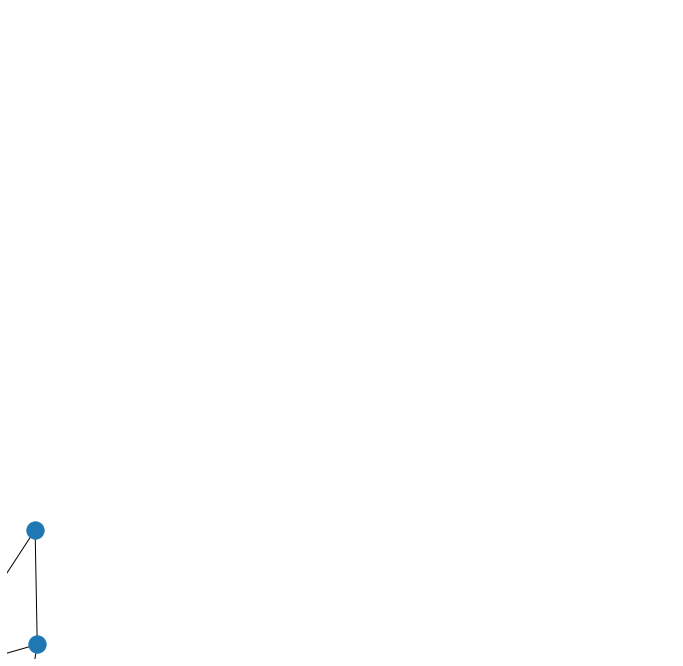

In [111]:
import networkx as nx
import pylab
G=nx.Graph()
G.add_edge(20*'a',20*'b')
G.add_edge(20*'b',20*'c')
G.add_edge(20*'c',20*'d')
G.add_edge(20*'d',20*'a')
G.add_edge(20*'a',20*'c')
pos=nx.spring_layout(G)
#pylab.figure(1,figsize=(3,3))
pylab.figure(1,figsize=(12,12))
pylab.xlim(0,5)
pylab.ylim(0,5)
nx.draw(G,pos,font_size=1)
#nx.draw(G,pos,font_size=10)
pylab.show()

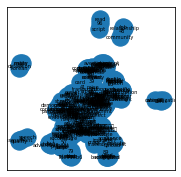

In [116]:
#drawing bipartite network with a quick spring layout
pylab.figure(1,figsize=(3,3))
nx.draw_networkx(g_2mode, font_size=5)

    With no filtering, this will not bring insight (see below). If we want even faster computation and tunable visualizations, check out Pajek or gephi.



    A two-mode network can be easily transformed into two one-mode network, enabling words to be connected to other words via the number of documents that share them, or documents to be connected to other documents via the words they share:

G = nx.generators.balanced_tree(3,3)
pos = nx.drawing.spring_layout(G)

scale = 1.25

In [98]:
#one-mode network
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [99]:
gDoc = contractNetwork(g_2mode, 'doc')

In [100]:
#details of document-to-document network
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 608
Average degree:  12.1600


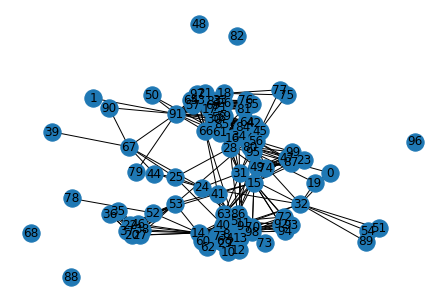

In [106]:
#constructing visualization 
#using edge weight to distinguish document distance (modeled as attraction)

layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

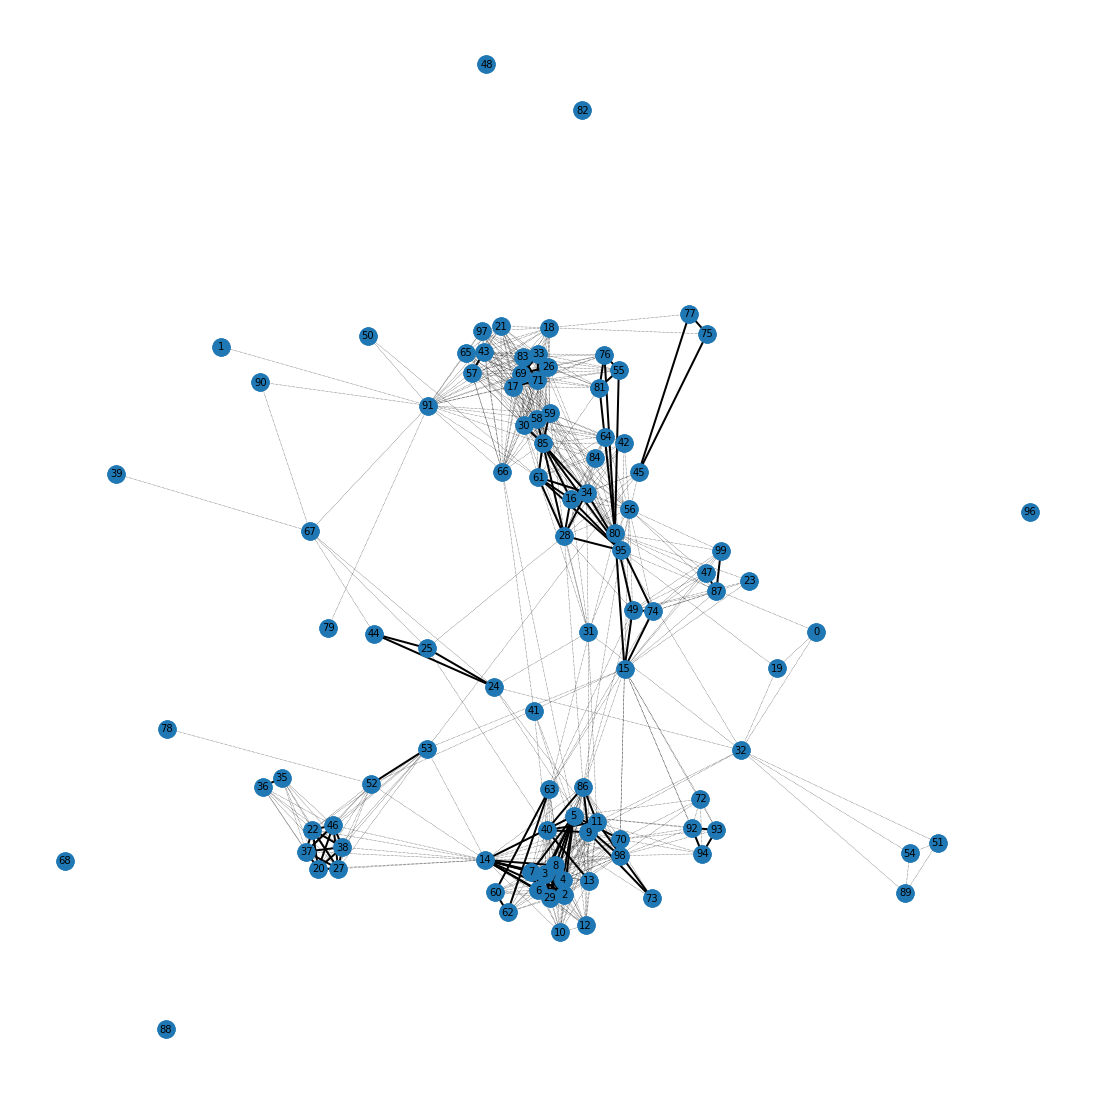

In [128]:
#drawing graph with with high and low weight edges distinguished
pylab.figure(1,figsize=(15,15))

wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5, font_size=10)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2, font_size=10)

In [103]:
#looking at outlying nodes

print(len(df.iloc[96]['Title']),"words:","\n",df.iloc[96]['Title'].strip().replace('  ', '\n'))
print(len(df.iloc[68]['Title']),"words:","\n",df.iloc[68]['Title'].strip().replace('  ', '\n'))
print(len(df.iloc[88]['Title']),"words:","\n",df.iloc[88]['Title'].strip().replace('  ', '\n'))
print(len(df.iloc[82]['Title']),"words:","\n",df.iloc[82]['Title'].strip().replace('  ', '\n'))
print(len(df.iloc[48]['Title']),"words:","\n",df.iloc[48]['Title'].strip().replace('  ', '\n'))

14 words: 
 Script Reading
27 words: 
 Canis Animal Categorization
29 words: 
 Korean Named Entity Detection
25 words: 
 Speech quality assessment
49 words: 
 Well-being and Relationships in the LGB Community


a variable number of words.  the rarity of certain keywords is likely responsible for them being outliers.  

In [123]:
#looking at inner nodes
print(len(df.iloc[69]['Title']),"words:","\n",df.iloc[69]['Title'].strip().replace('  ', '\n'))

print(len(df.iloc[80]['Title']),"words:","\n",df.iloc[80]['Title'].strip().replace('  ', '\n'))
print(len(df.iloc[15]['Title']),"words:","\n",df.iloc[15]['Title'].strip().replace('  ', '\n'))
print(len(df.iloc[74]['Title']),"words:","\n",df.iloc[74]['Title'].strip().replace('  ', '\n'))

print(len(df.iloc[3]['Title']),"words:","\n",df.iloc[3]['Title'].strip().replace('  ', '\n'))
print(len(df.iloc[38]['Title']),"words:","\n",df.iloc[38]['Title'].strip().replace('  ', '\n'))


35 words: 
 Answer a survey about your opinions
121 words: 
 Moderate Customer-Supplied Question & Answers (WARNING: This HIT may contain adult content. Worker discretion is advised)
119 words: 
 Collect store information of a hiring sign (WARNING: This HIT may contain adult content. Worker discretion is advised.)
115 words: 
 How do you feel when seeing a painting?(WARNING: This HIT may contain adult content. Worker discretion is advised.)
47 words: 
 Extract purchased items from a shopping receipt
15 words: 
 Transcribe data


a combination of long-lengths and highly common keywords is likely responsible for their centrality.

In [131]:
#high-weight cluster 1
print(len(df.iloc[22]['Title']),"words:","\n",df.iloc[22]['Title'].strip().replace('  ', '\n'))
print(len(df.iloc[38]['Title']),"words:","\n",df.iloc[38]['Title'].strip().replace('  ', '\n'))
print(len(df.iloc[20]['Title']),"words:","\n",df.iloc[20]['Title'].strip().replace('  ', '\n'))

15 words: 
 Transcribe data
15 words: 
 Transcribe data
15 words: 
 Transcribe data


"transcribe data"

In [129]:
#high-weight cluster 2
print(len(df.iloc[83]['Title']),"words:","\n",df.iloc[83]['Title'].strip().replace('  ', '\n'))
print(len(df.iloc[26]['Title']),"words:","\n",df.iloc[26]['Title'].strip().replace('  ', '\n'))
print(len(df.iloc[69]['Title']),"words:","\n",df.iloc[69]['Title'].strip().replace('  ', '\n'))

44 words: 
 Answer a survey about memory and preferences
75 words: 
 Answer a survey about your opinions toward a nonprofit and its partnerships
35 words: 
 Answer a survey about your opinions


"Answer a survey about"

In [126]:
#high-weight cluster 3
print(len(df.iloc[28]['Title']),"words:","\n",df.iloc[28]['Title'].strip().replace('  ', '\n'))
print(len(df.iloc[85]['Title']),"words:","\n",df.iloc[85]['Title'].strip().replace('  ', '\n'))
print(len(df.iloc[61]['Title']),"words:","\n",df.iloc[61]['Title'].strip().replace('  ', '\n'))



55 words: 
 Timing review - Earn up to $0.18 per timed media minute
70 words: 
 Follow-up Survey About Working Online (~5 minutes, $0.50)(~ 5 minutes)
58 words: 
 Play a Virus Slayer video game and earn $15!(~ 60 minutes)


"minute\s"

In [130]:
#high-weight cluster 4
print(len(df.iloc[80]['Title']),"words:","\n",df.iloc[80]['Title'].strip().replace('  ', '\n'))
print(len(df.iloc[15]['Title']),"words:","\n",df.iloc[15]['Title'].strip().replace('  ', '\n'))
print(len(df.iloc[74]['Title']),"words:","\n",df.iloc[74]['Title'].strip().replace('  ', '\n'))

121 words: 
 Moderate Customer-Supplied Question & Answers (WARNING: This HIT may contain adult content. Worker discretion is advised)
119 words: 
 Collect store information of a hiring sign (WARNING: This HIT may contain adult content. Worker discretion is advised.)
115 words: 
 How do you feel when seeing a painting?(WARNING: This HIT may contain adult content. Worker discretion is advised.)


"(WARNING: This HIT may contain adult content. Worker discretion is advised)"

In [167]:
#examining the word-to-word network by documents
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 279
Number of edges: 1219
Average degree:   8.7384


In [253]:
#reducing the size of the word collection
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.3002461033634127

In [269]:
g = wordCooccurrence(df['normalized_sents'][:4000].sum())
len(g)

1434

    We are going to return to the sentence cooccurence graph, as it suggests many more meaningful (more local) associations. But without filtering, it is too large. Let's first drop all the edges with weight below 25, then drop all the isolates. You are recommended to play with the weight here to see how the graph might look different.

In [274]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 15])

In [275]:
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

In [276]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [277]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 167
Number of edges: 382
Average degree:   4.5749


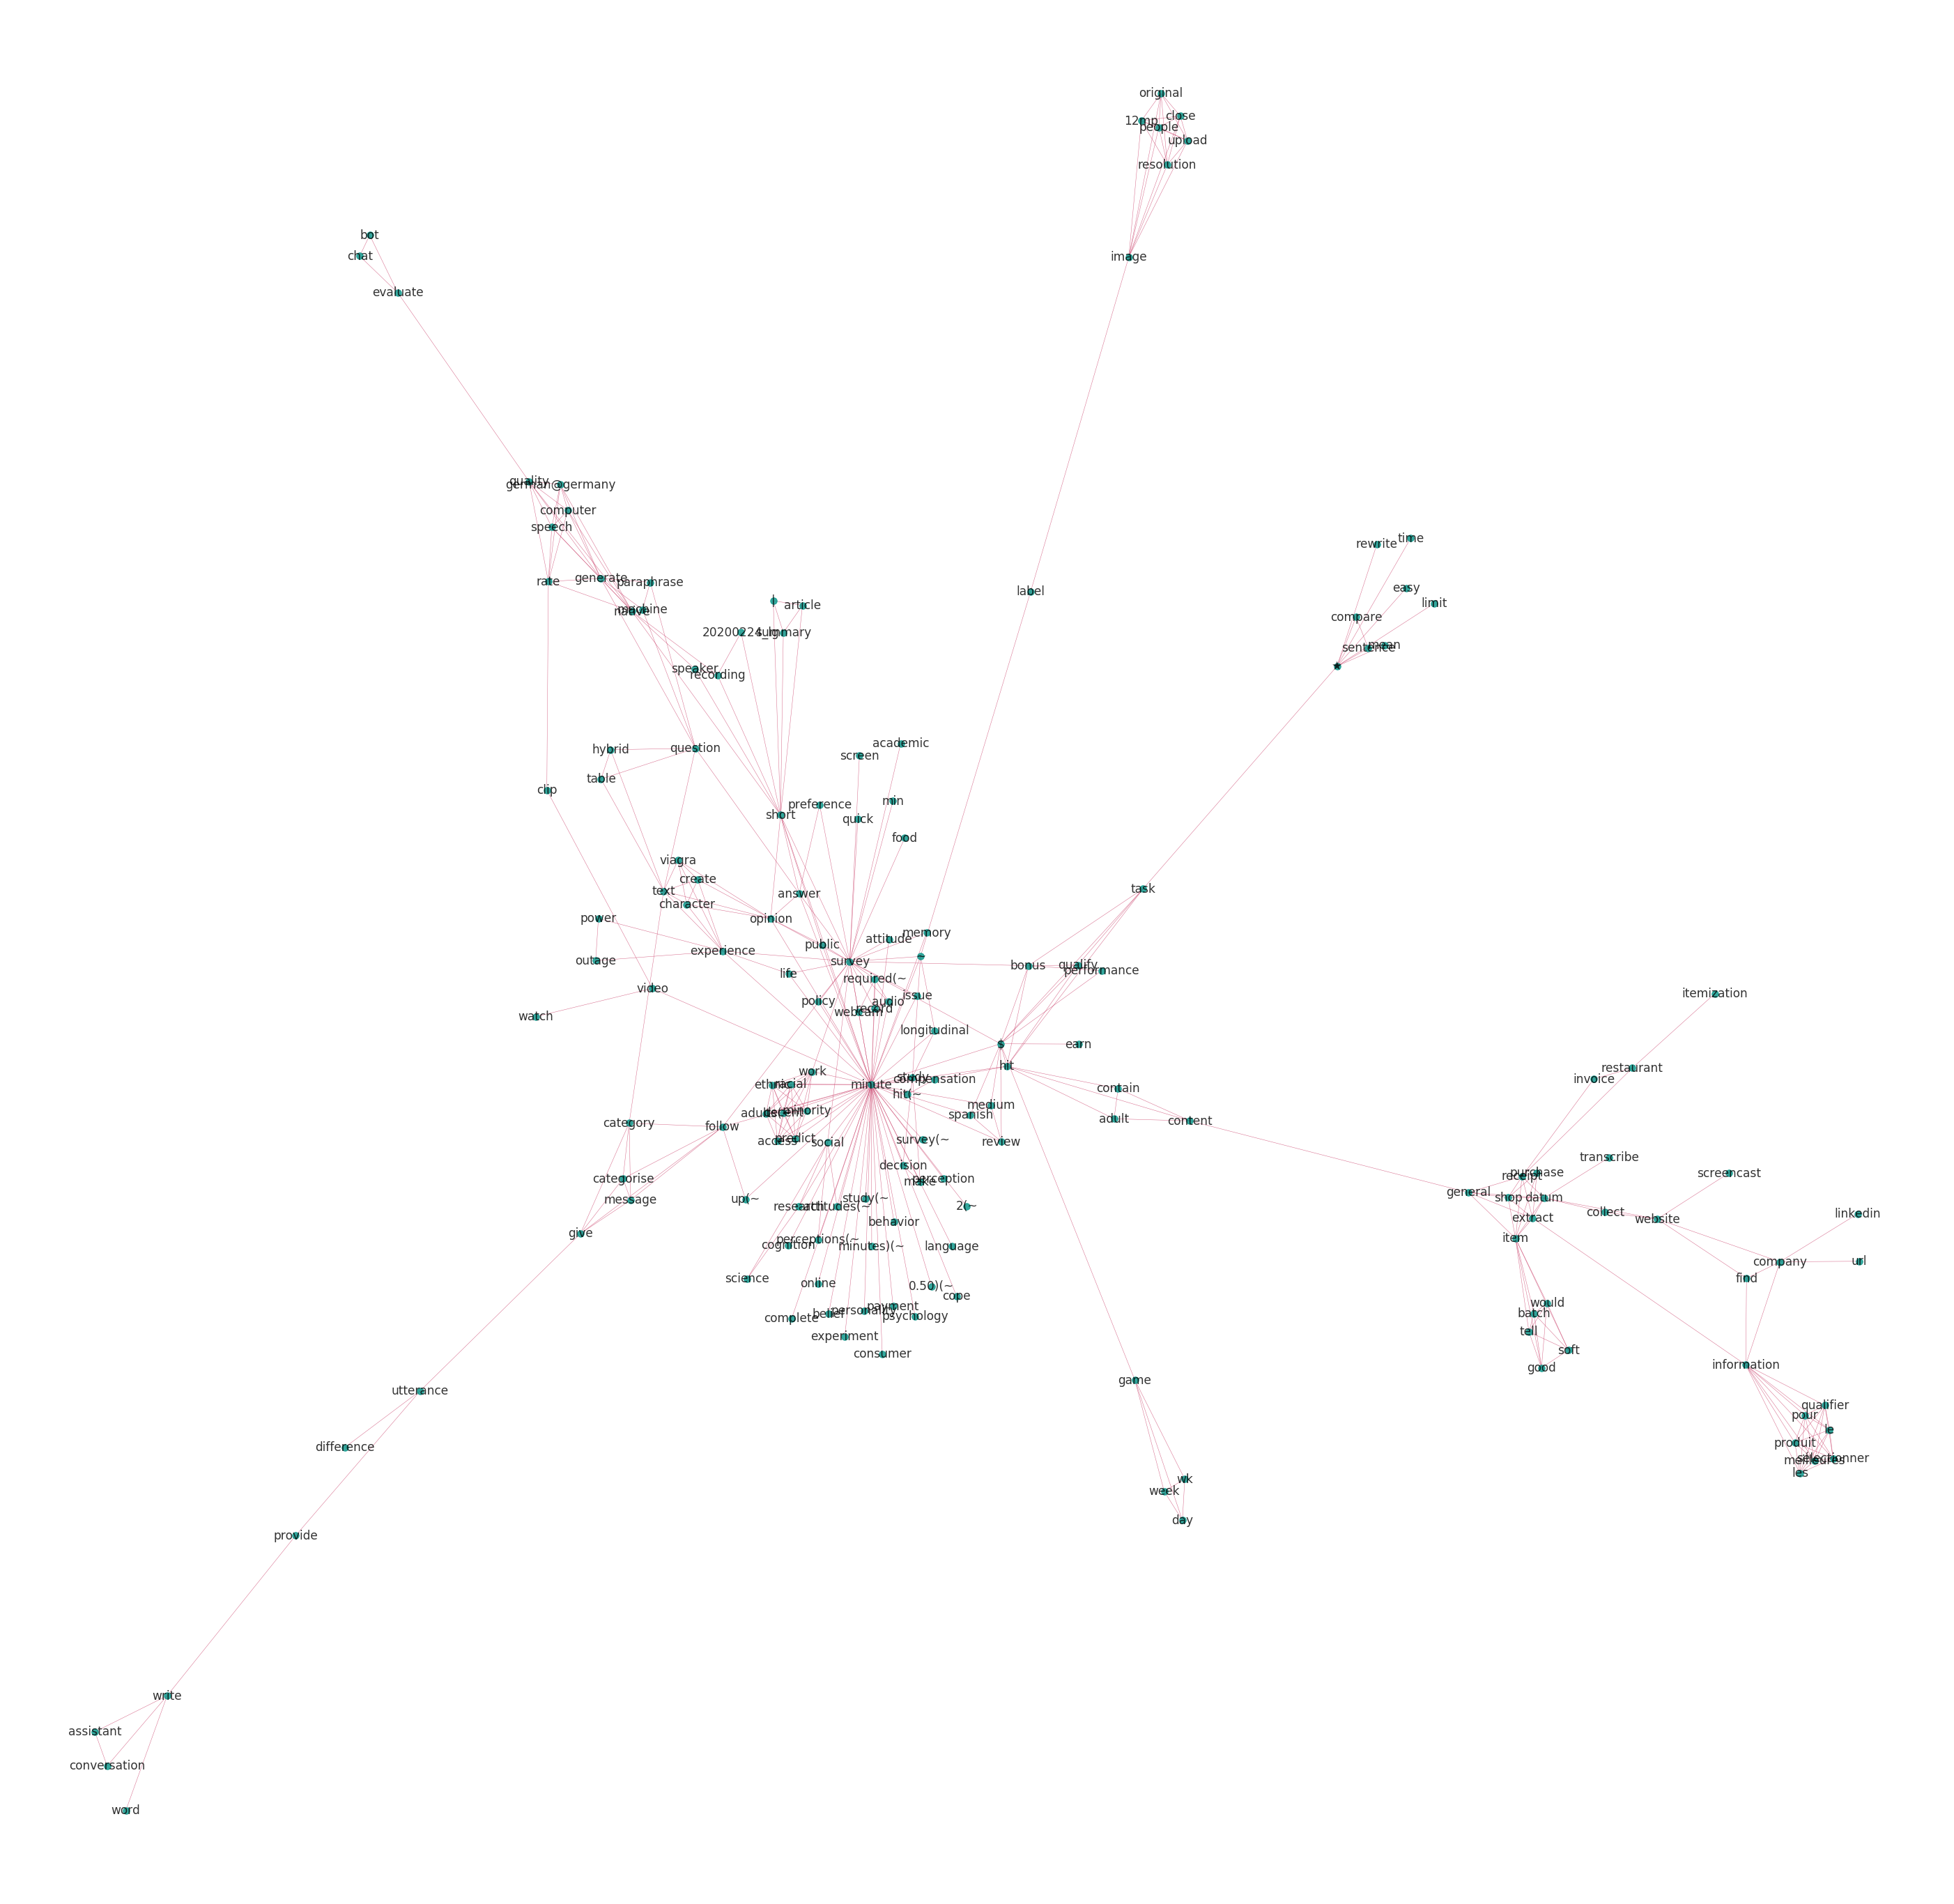

In [297]:
#visualizing the giant connected component
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (50,50))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.5, 
        alpha = 0.8, 
        node_size = 90,
        font_size = 17,
        font_color = "xkcd:black",
        node_color = "xkcd:teal",
        edge_color='xkcd:dark pink') #Getting labels is a bit annoying

    Let us use this oppurtunity to introduce a concept of finding communities in graphs: a popular one is the modularity measure, introduced in: Clauset, A., Newman, M. E., & Moore, C. “Finding community structure in very large networks.” Physical Review E 70(6), 2004.

In [299]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(giant))

    networkx implements this through the above method. It yields sets of nodes, one for each community.

In [300]:
#community c
c

[frozenset({'$',
            '0.50)(~',
            '12mp',
            '2(~',
            '20200224_lg',
            'academic',
            'access',
            'adult',
            'adults(~',
            'answer',
            'article',
            'assistant',
            'attitude',
            'attitudes(~',
            'audio',
            'behavior',
            'belief',
            'bonus',
            'bot',
            'categorise',
            'category',
            'character',
            'chat',
            'clip',
            'close',
            'cognition',
            'compare',
            'compensation',
            'complete',
            'computer',
            'consumer',
            'contain',
            'content',
            'conversation',
            'cope',
            'create',
            'day',
            'decent',
            'decision',
            'difference',
            'earn',
            'easy',
            'ethnic',
            'evaluate'

    We can also remove those words that show up in many documents...those with many connections (note that this has a similar effect to selecting those with a high tf.idf score). Note that for this case we get the same graph; this is just to demonstrate the different kinds of node dropping and graph changes we can do.

In [301]:
giant = nx.Graph(giant)

In [302]:
giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 2000]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 167
Number of edges: 382
Average degree:   4.5749


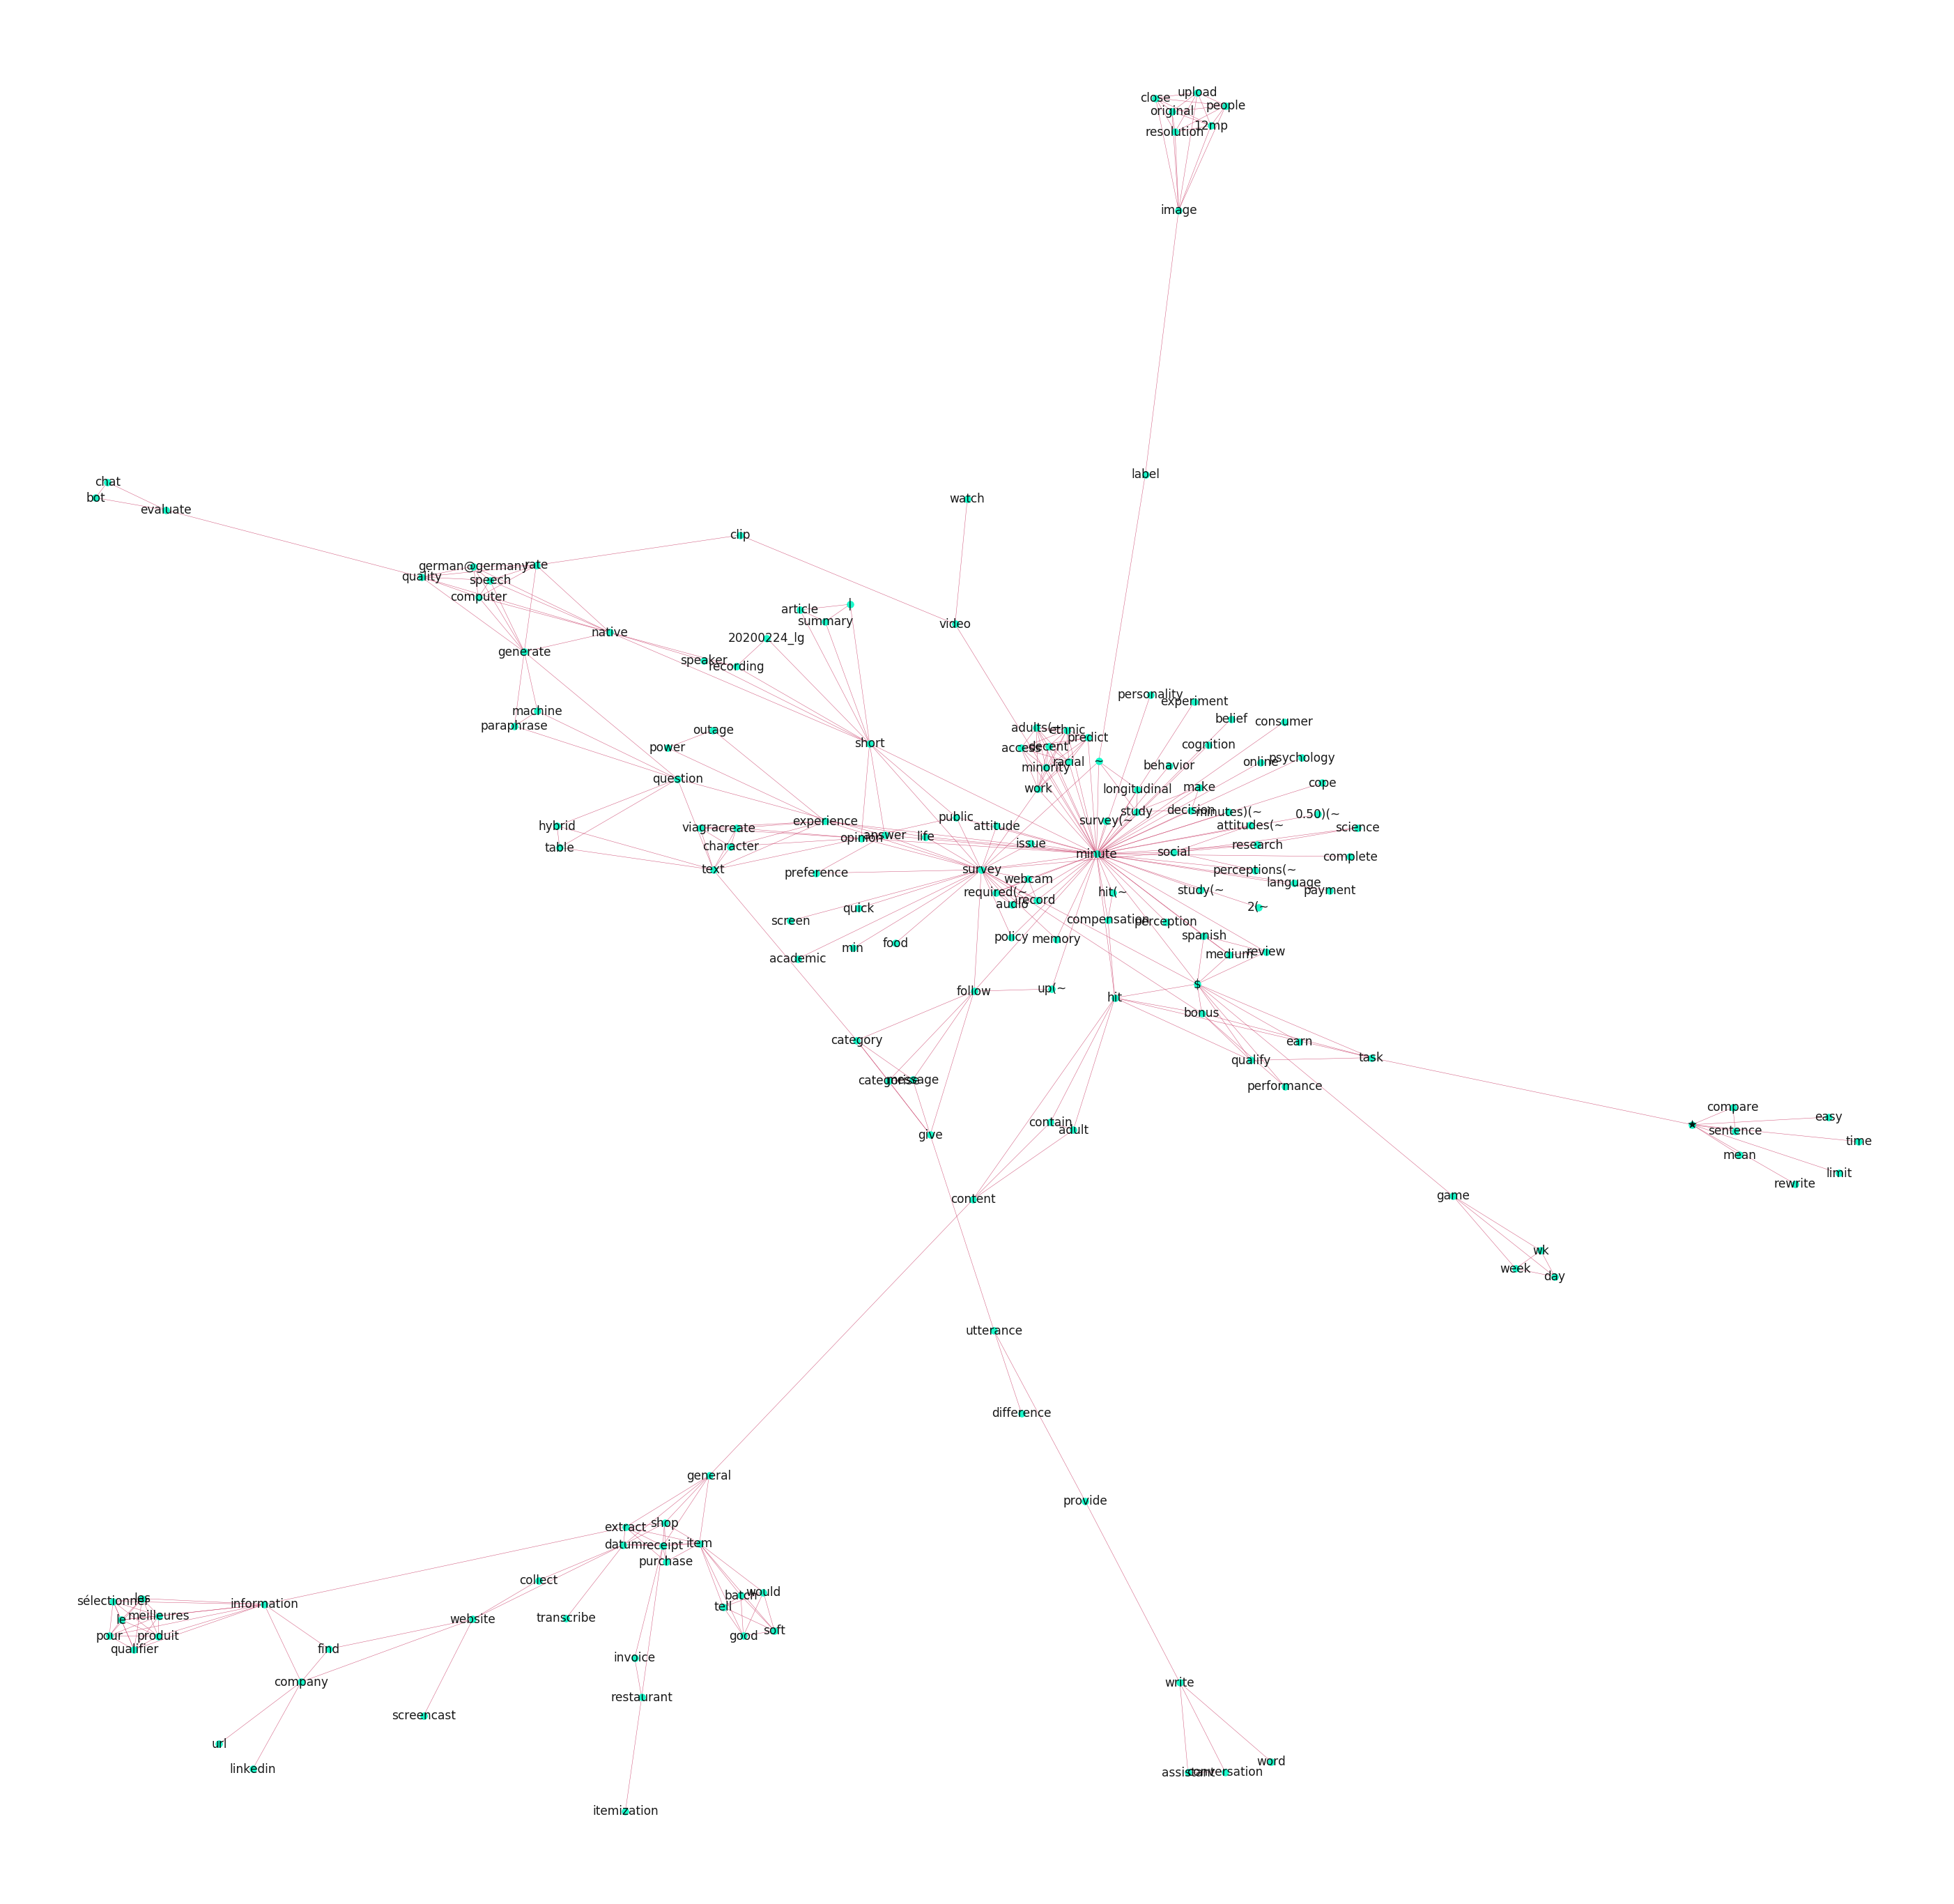

In [322]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (50,50))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.5, 
        alpha = 0.9, 
        node_size = 90,
        font_size = 17,
        font_color = "xkcd:black",
        node_color = "xkcd:bright teal",
        edge_color='xkcd:dark pink') #Getting labels is a bit annoying

    We can continue to trim globally to investigate the structure of words at alternative slices of network density.

    Moreover, we can find cliques, or completely connected sets of nodes.

In [304]:
#fidning cliques (completely connected sets of nodes)
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

minute, minority, adults(~, ethnic, work, racial, access, predict, decent


In [305]:
#examining a subgraph of the network:
#(nodes within 1-2 network steps of "extract")
extractNeighbors = giant.neighbors('extract')
g_extract = giant.subgraph(extractNeighbors)
print(nx.info(g_extract))

Name: 
Type: Graph
Number of nodes: 7
Number of edges: 14
Average degree:   4.0000


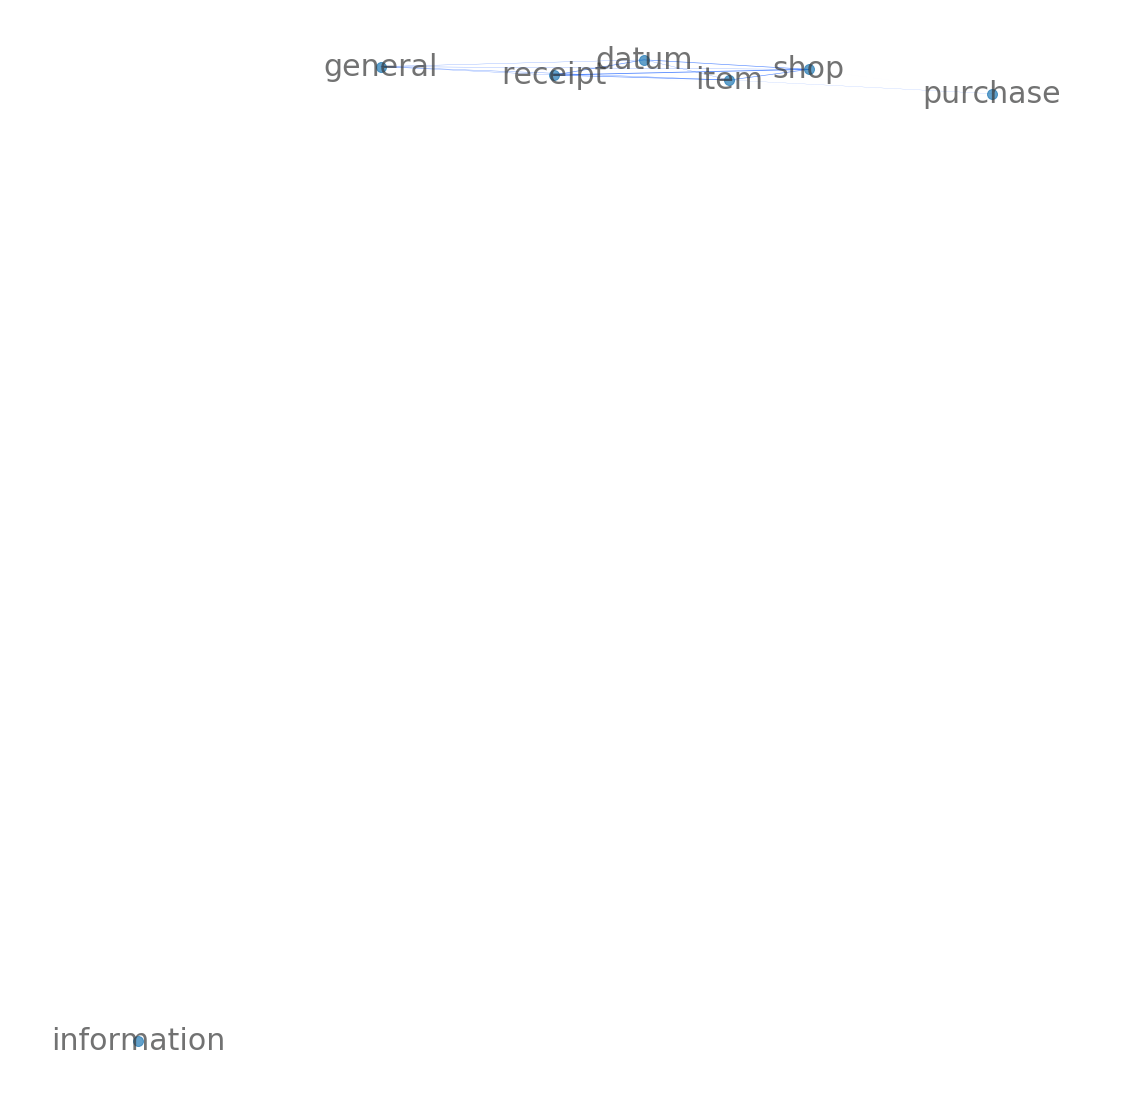

In [320]:
#graphing extractNeighbors
layout_extract = nx.spring_layout(g_extract, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (20,20))
maxWeight = max((d['weight'] for n1, n2, d in g_extract.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_extract.edges(data = True)))
nx.draw(g_extract, ax = ax, pos = layout_extract, labels = {n:n for n in g_extract.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_extract.edges(data = True)], 
        alpha = .7, 
        font_size = 30,
        node_size = 100,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:electric blue',
        cmap = plt.get_cmap('plasma')) 

In [343]:

extractNeighbors = gWord.neighbors('extract')
extractNeighborsPlus1 = set(extractNeighbors)
for n in extractNeighbors:
    extractNeighborsPlus1 |= set(giant.neighbors(n))
    
for x in extractNeighborsPlus1:
    print(x)

shop
purchase
information
receipt
item
invoice
summary
business
datum


In [326]:
#g_extract2
g_extract2 = giant.subgraph(extractNeighborsPlus1)
print(nx.info(g_extract2))

Name: 
Type: Graph
Number of nodes: 8
Number of edges: 11
Average degree:   2.7500


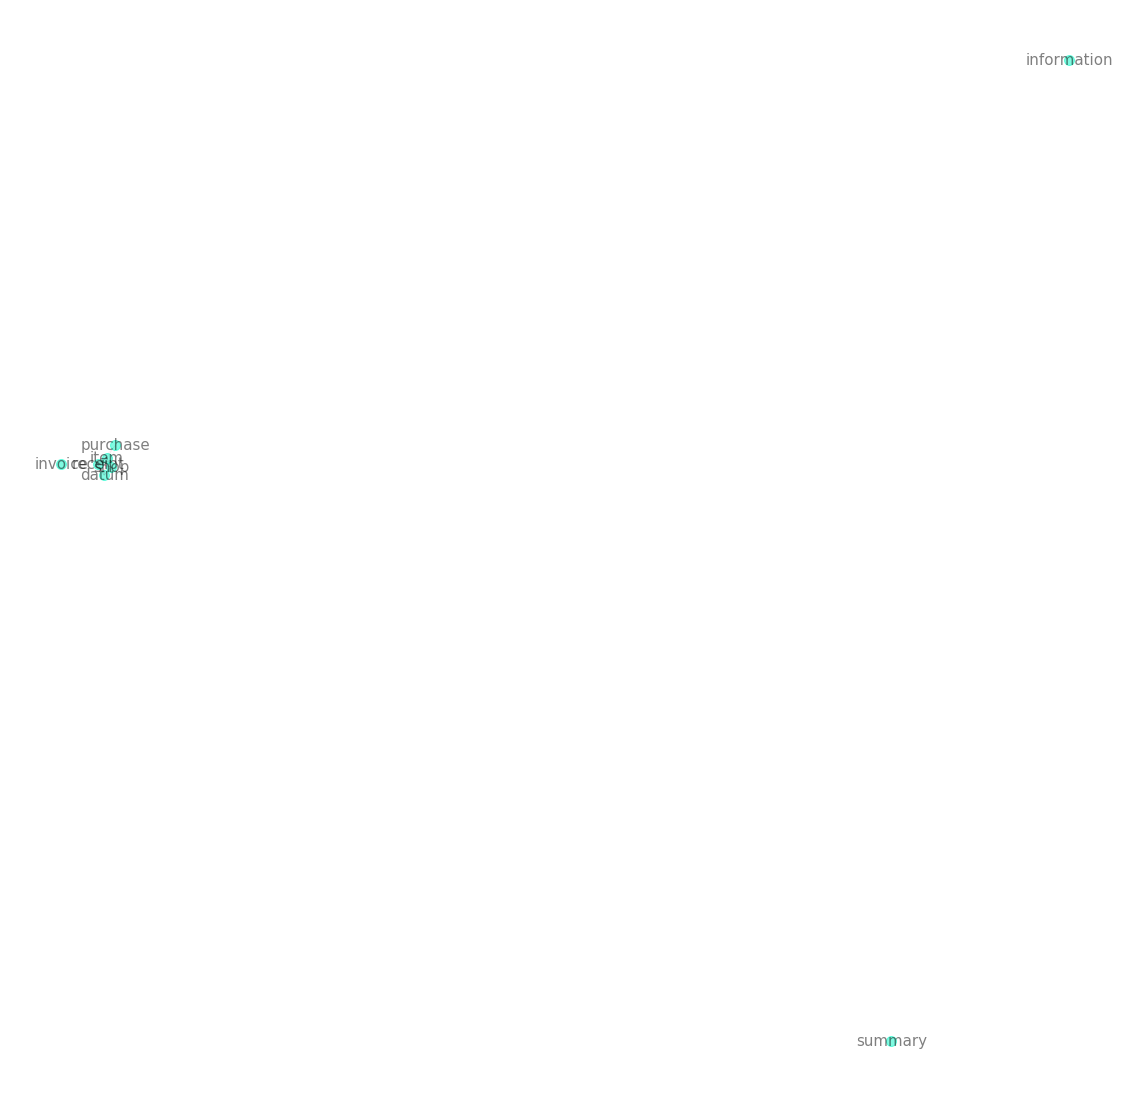

In [342]:
#graphing extractNeighborsPlus1
layout_extract = nx.spring_layout(g_extract2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (20,20))
centralities_extract = nx.eigenvector_centrality(g_extract2)
maxC = max(centralities_extract.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_extract2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_extract2.edges(data = True)))
nx.draw(g_extract2, ax = ax, pos = layout_extract, labels = {n:n for n in g_extract2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_extract2.edges(data = True)],
        alpha = 0.5, 
        node_size = 100,
        font_size = 15,
        font_color = "xkcd:black",
        node_color = "xkcd:bright teal",
        edge_color='xkcd:dark pink',
        cmap = plt.get_cmap('plasma')) 

these plots show that, of the neighbors adjacent to "extract", all are very clique-y except for "information" and "summary" -- these two words describe formats for extracted data, while the others (shop, purchse, item, invoice, etc) all describe types of data or data objects.  

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that calculate different kinds of centrality for distinct words or documents in a network composed from your corpus of interest. Which type of words tend to be most and least central? Can you identify how different centrality measures distinguish different kind of words in your corpus? What do these patterns suggest about the semantic content and structure of your documents? Finally, calculate global measure for your network(s) and discuss what they reveal.

# Network Statistics
We can often gain more insight into our semantic network through statistics that describe the positions of words within it.

We begin with measures of centrality. The concept of centrality is that some nodes (words or documents) are more *central* to the network than others. The most straightforward is the notion of degree centrality: those nodes that have the highest number of connections are the most central. Here our measure normalizes the number of connections by those with the most connections.

In [346]:
dcentralities = nx.degree_centrality(giant)

In [348]:
dcentralities['extract']

0.042168674698795185

In [349]:
#returning element with largest centrality 
max(dcentralities.items(), key = lambda x : x[1])

('minute', 0.3734939759036145)

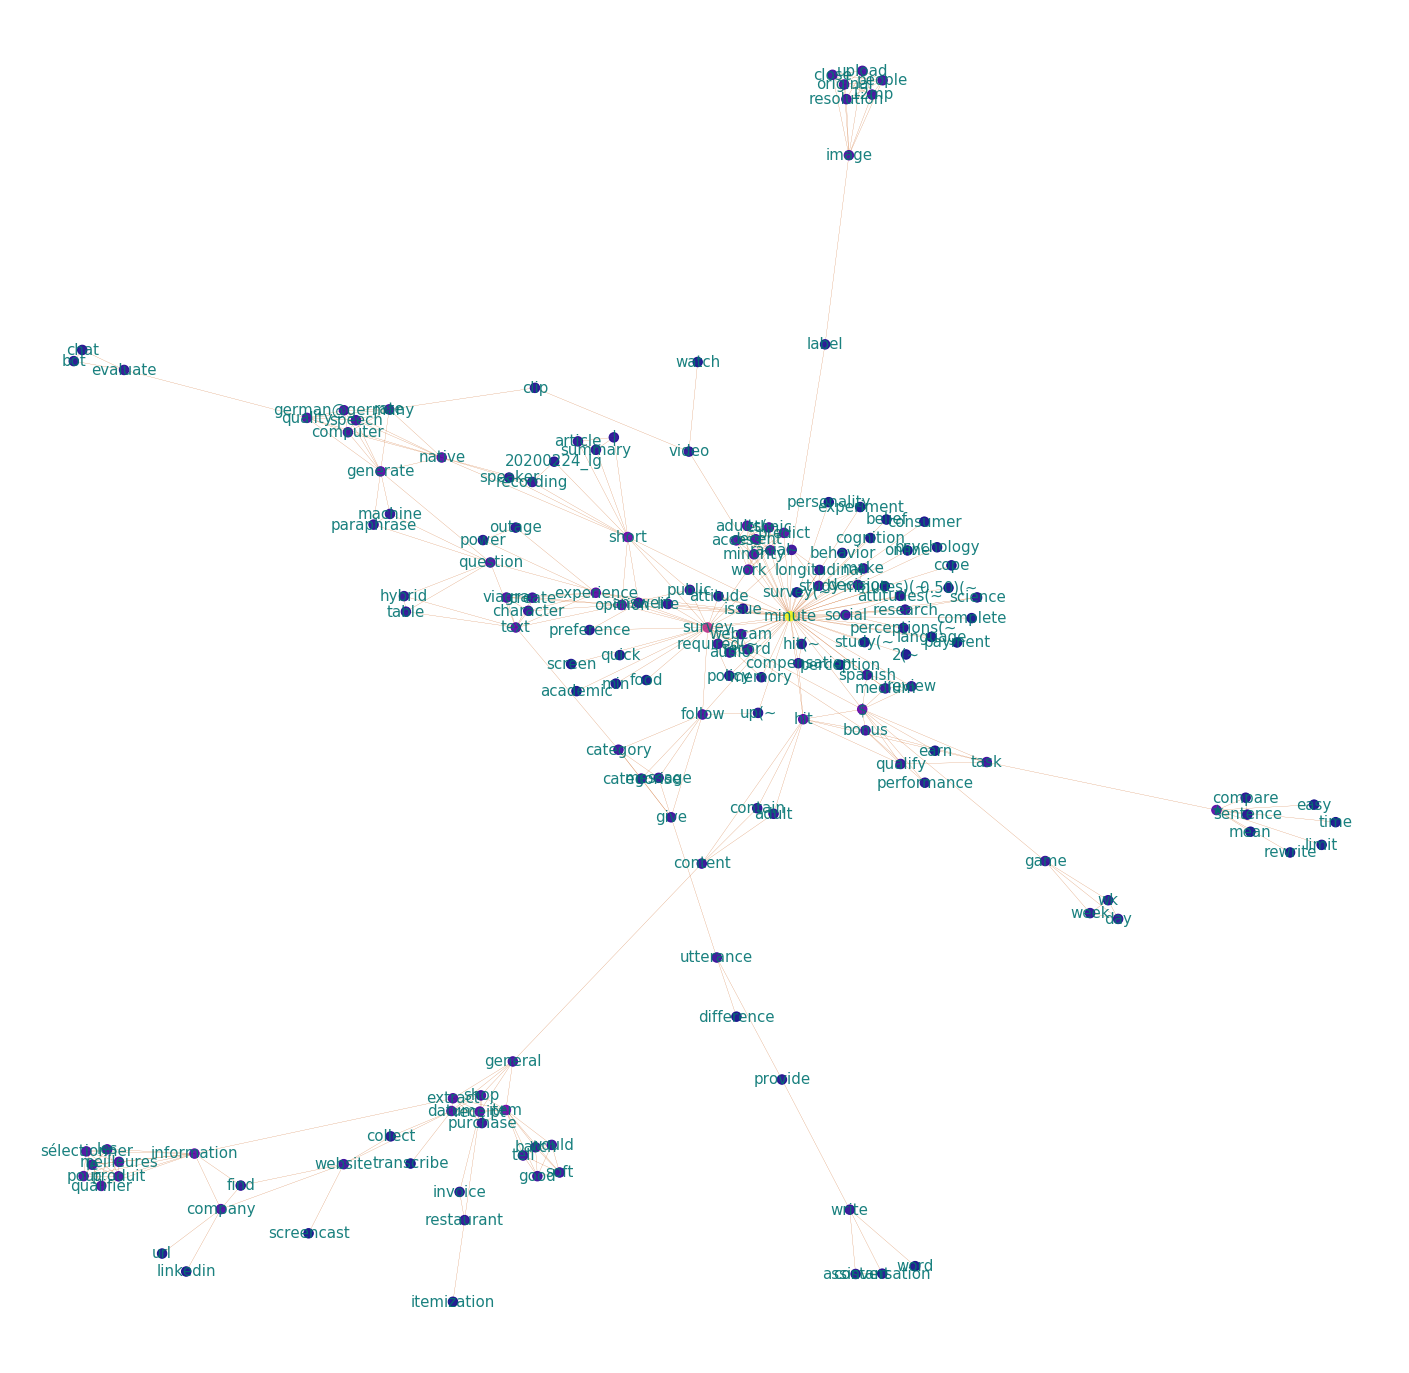

In [394]:
#coloring/sizing nodes by betweeness centrality
fig, ax = plt.subplots(figsize = (25,25))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = 0.9, 
        node_size = 90,
        font_size = 15,
        font_color = "xkcd:dark aquamarine",
        #node_color = "xkcd:bright teal",
        edge_color='xkcd:dark orange',
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

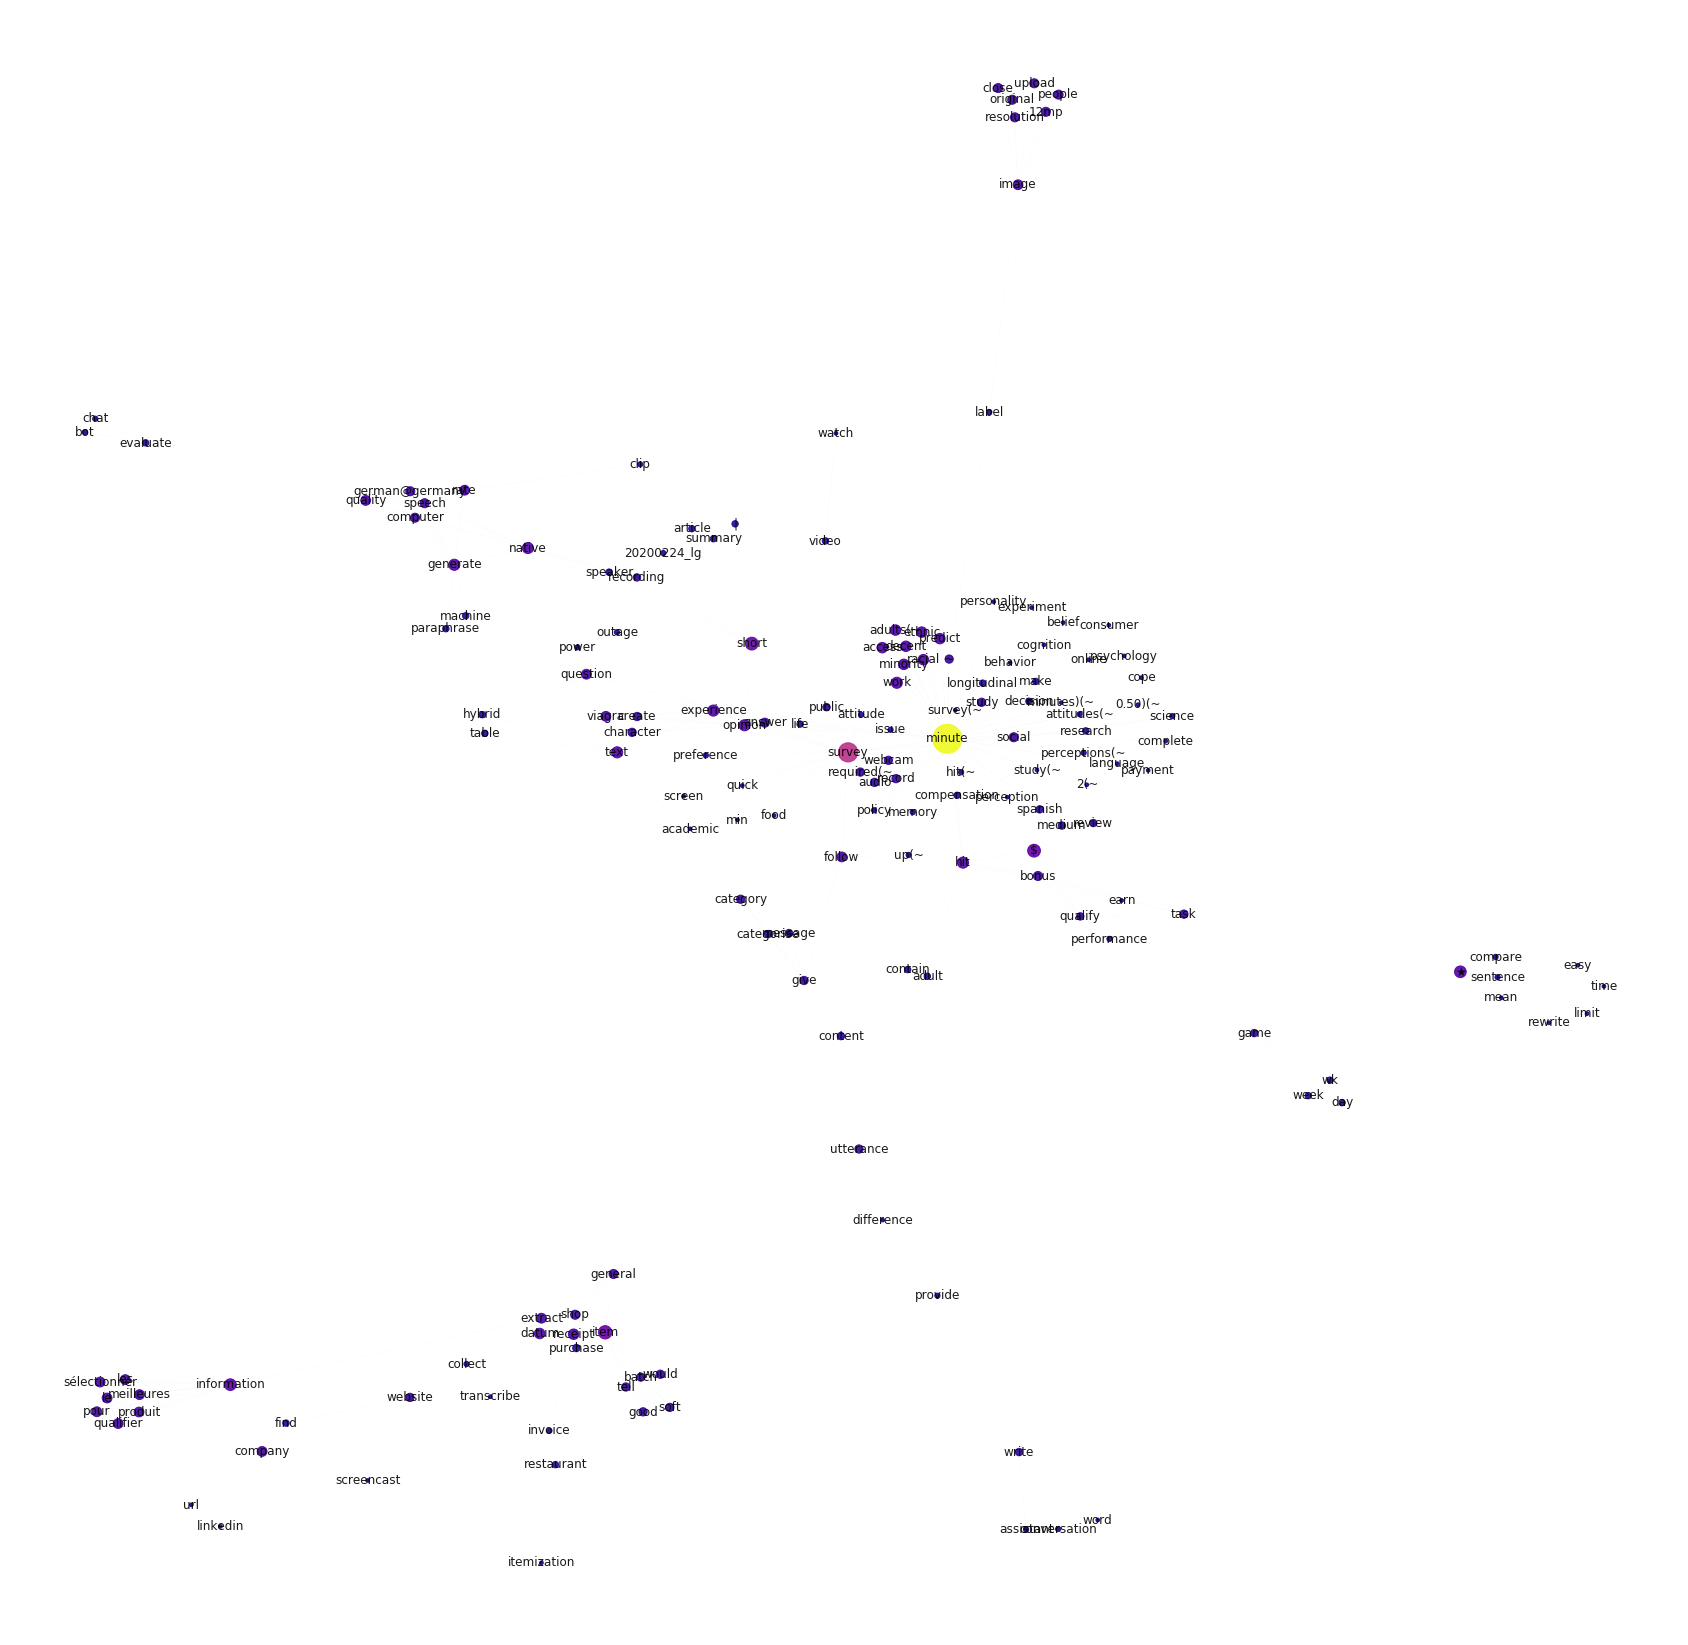

In [425]:
#using node size to represent degree centrality and edge weight
#coloring/sizing nodes by betweeness centrality
fig, ax = plt.subplots(figsize = (30,30))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .9) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = 0.9, 
        font_size = 12,
        font_color = "xkcd:black",
        edge_color='xkcd:black',
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 850 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

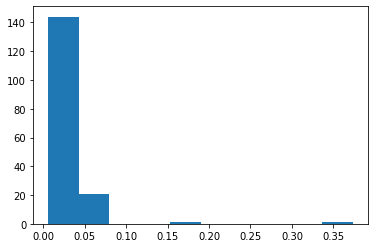

In [416]:
#plotting the distribution of degree centrality
plt.hist(list(dcentralities.values()))
plt.show()

In [417]:
#Top 10 words ranked by degree
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('minute', 0.3734939759036145),
 ('survey', 0.16265060240963855),
 ('item', 0.0783132530120482),
 ('short', 0.07228915662650603),
 ('$', 0.07228915662650603),
 ('★', 0.060240963855421686),
 ('information', 0.060240963855421686),
 ('text', 0.05421686746987952),
 ('opinion', 0.05421686746987952),
 ('experience', 0.05421686746987952)]

In [418]:
#Bottom 10 words ranked by degree
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('quick', 0.006024096385542169),
 ('rewrite', 0.006024096385542169),
 ('2(~', 0.006024096385542169),
 ('transcribe', 0.006024096385542169),
 ('time', 0.006024096385542169),
 ('min', 0.006024096385542169),
 ('behavior', 0.006024096385542169),
 ('easy', 0.006024096385542169),
 ('survey(~', 0.006024096385542169),
 ('perception', 0.006024096385542169)]

    Consider another very different measure, which is betweenness centrality. Betweenness centrality distinguishes nodes that require the most shortest pathways between all other nodes in the network. Semantically, words with a high betweenness centrality may link distinctive domains, rather than being "central" to any one. In other words, high betweenness centrality nodes may not have the highest degree centrality.

In [420]:
#Betweenness Centrality of "extract"
centralities = nx.betweenness.betweenness_centrality(giant)
centralities['extract']

0.11290008518924181

In [421]:
#most betweenness central word
max(centralities.items(), key = lambda x : x[1])

('minute', 0.6703358890105879)

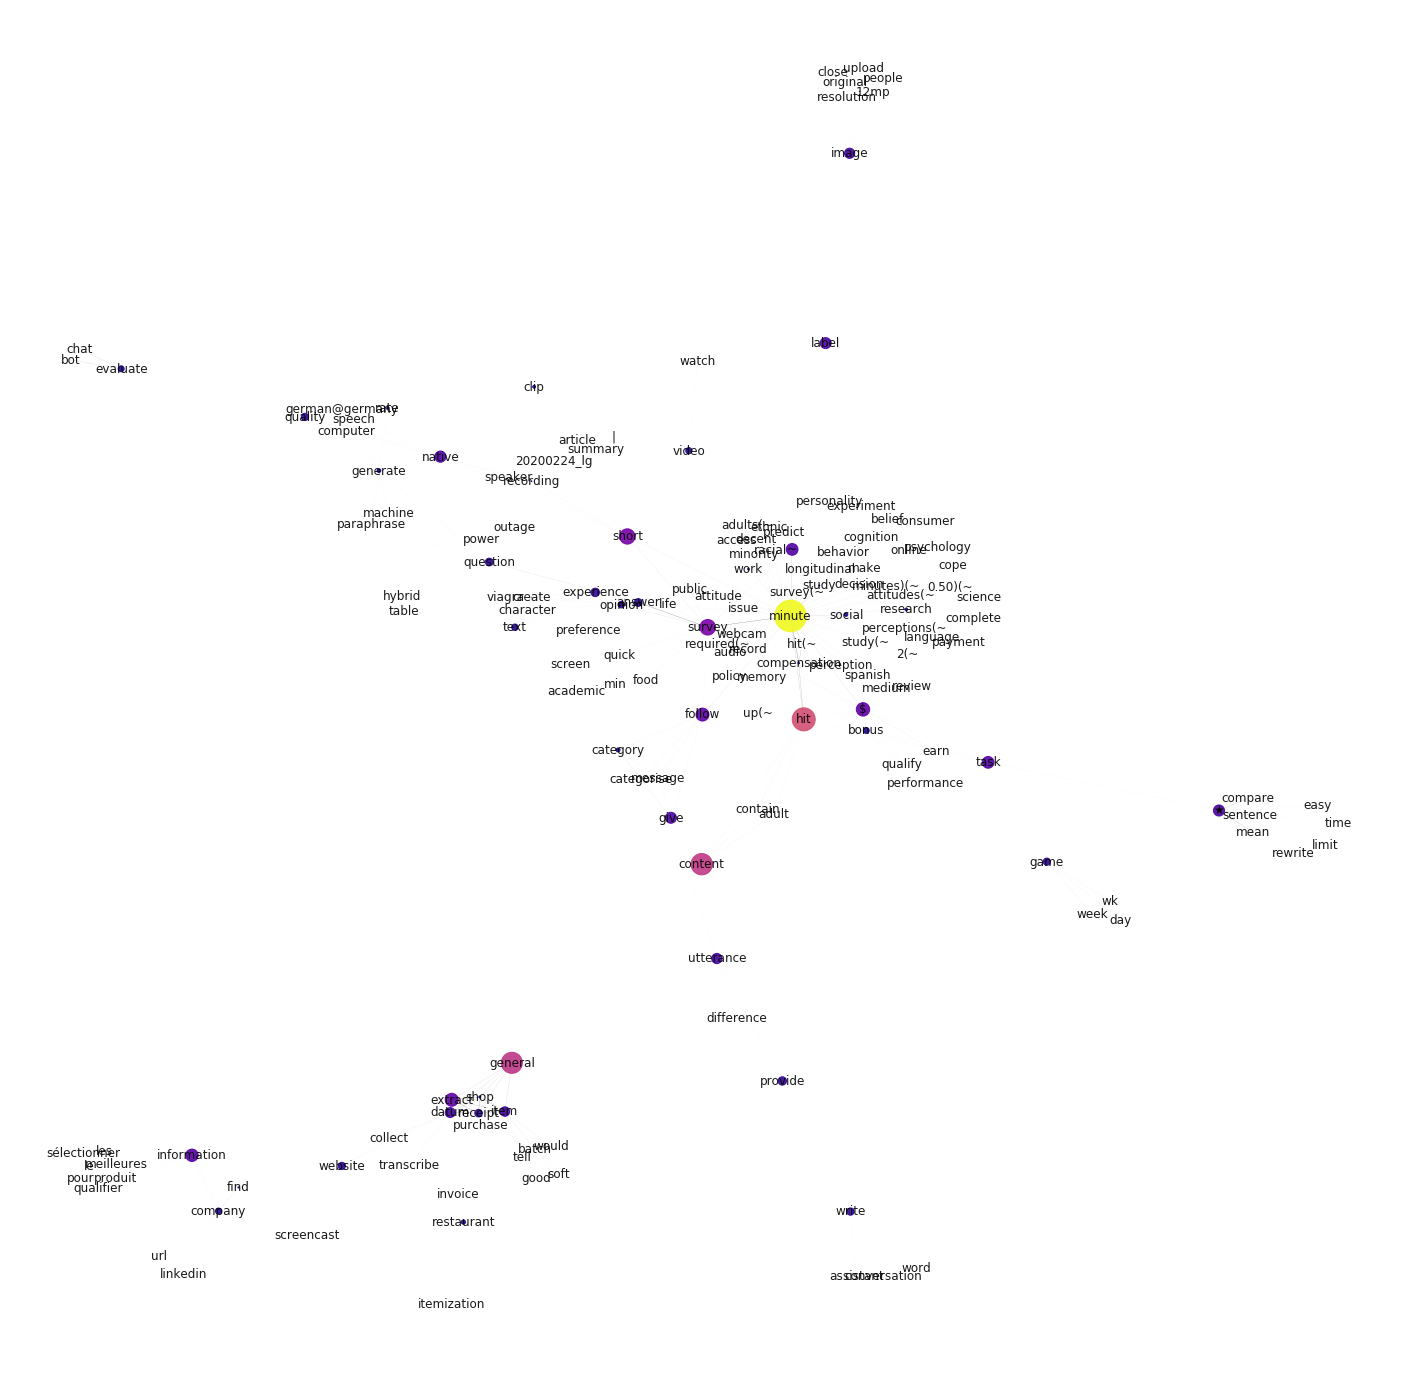

In [430]:
#coloring and sizing nodes by betweeness centrality
fig, ax = plt.subplots(figsize = (25,25))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = 0.9, 
        font_size = 12,
        font_color = "xkcd:black",
        edge_color='xkcd:black',
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 1000 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

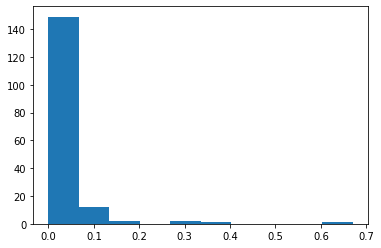

In [431]:
#graphing the distribution of betweenness centrality
plt.hist(list(centralities.values()))
plt.show()

appears to be an exponential distribution

In [432]:
#Top 10 words ranked by betweenness 
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('minute', 0.3734939759036145),
 ('survey', 0.16265060240963855),
 ('item', 0.0783132530120482),
 ('short', 0.07228915662650603),
 ('$', 0.07228915662650603),
 ('★', 0.060240963855421686),
 ('information', 0.060240963855421686),
 ('text', 0.05421686746987952),
 ('opinion', 0.05421686746987952),
 ('experience', 0.05421686746987952)]

"minute" is by far the word which links the most other concepts in the network.  this is likely because specifying time is both extremely important for attracting workers to a HIT and because it is a factor applicable across all types of HITs.  same explanation goes for "short" and "$" 

"survey" is next, likely for reason that it is a common format for HITs which is also relatively content-agnostic.  notable that it is associated at all with "extract" -- this connection warrants further exploration.

In [434]:
#50th-60th words ranked by betweennes
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[50:60]

[('answer', 0.03614457831325302),
 ('shop', 0.03614457831325302),
 ('batch', 0.030120481927710843),
 ('category', 0.030120481927710843),
 ('tell', 0.030120481927710843),
 ('would', 0.030120481927710843),
 ('create', 0.030120481927710843),
 ('soft', 0.030120481927710843),
 ('give', 0.030120481927710843),
 ('record', 0.030120481927710843)]

    We can also look at closeness centrality, or the average Euclidean or path distance between a node and all others in the network. A node with the highest closeness centrality is most likely to send a signal with the most coverage to the rest of the network.

In [435]:
#Closeness Centrality
centralities = nx.closeness_centrality(giant)

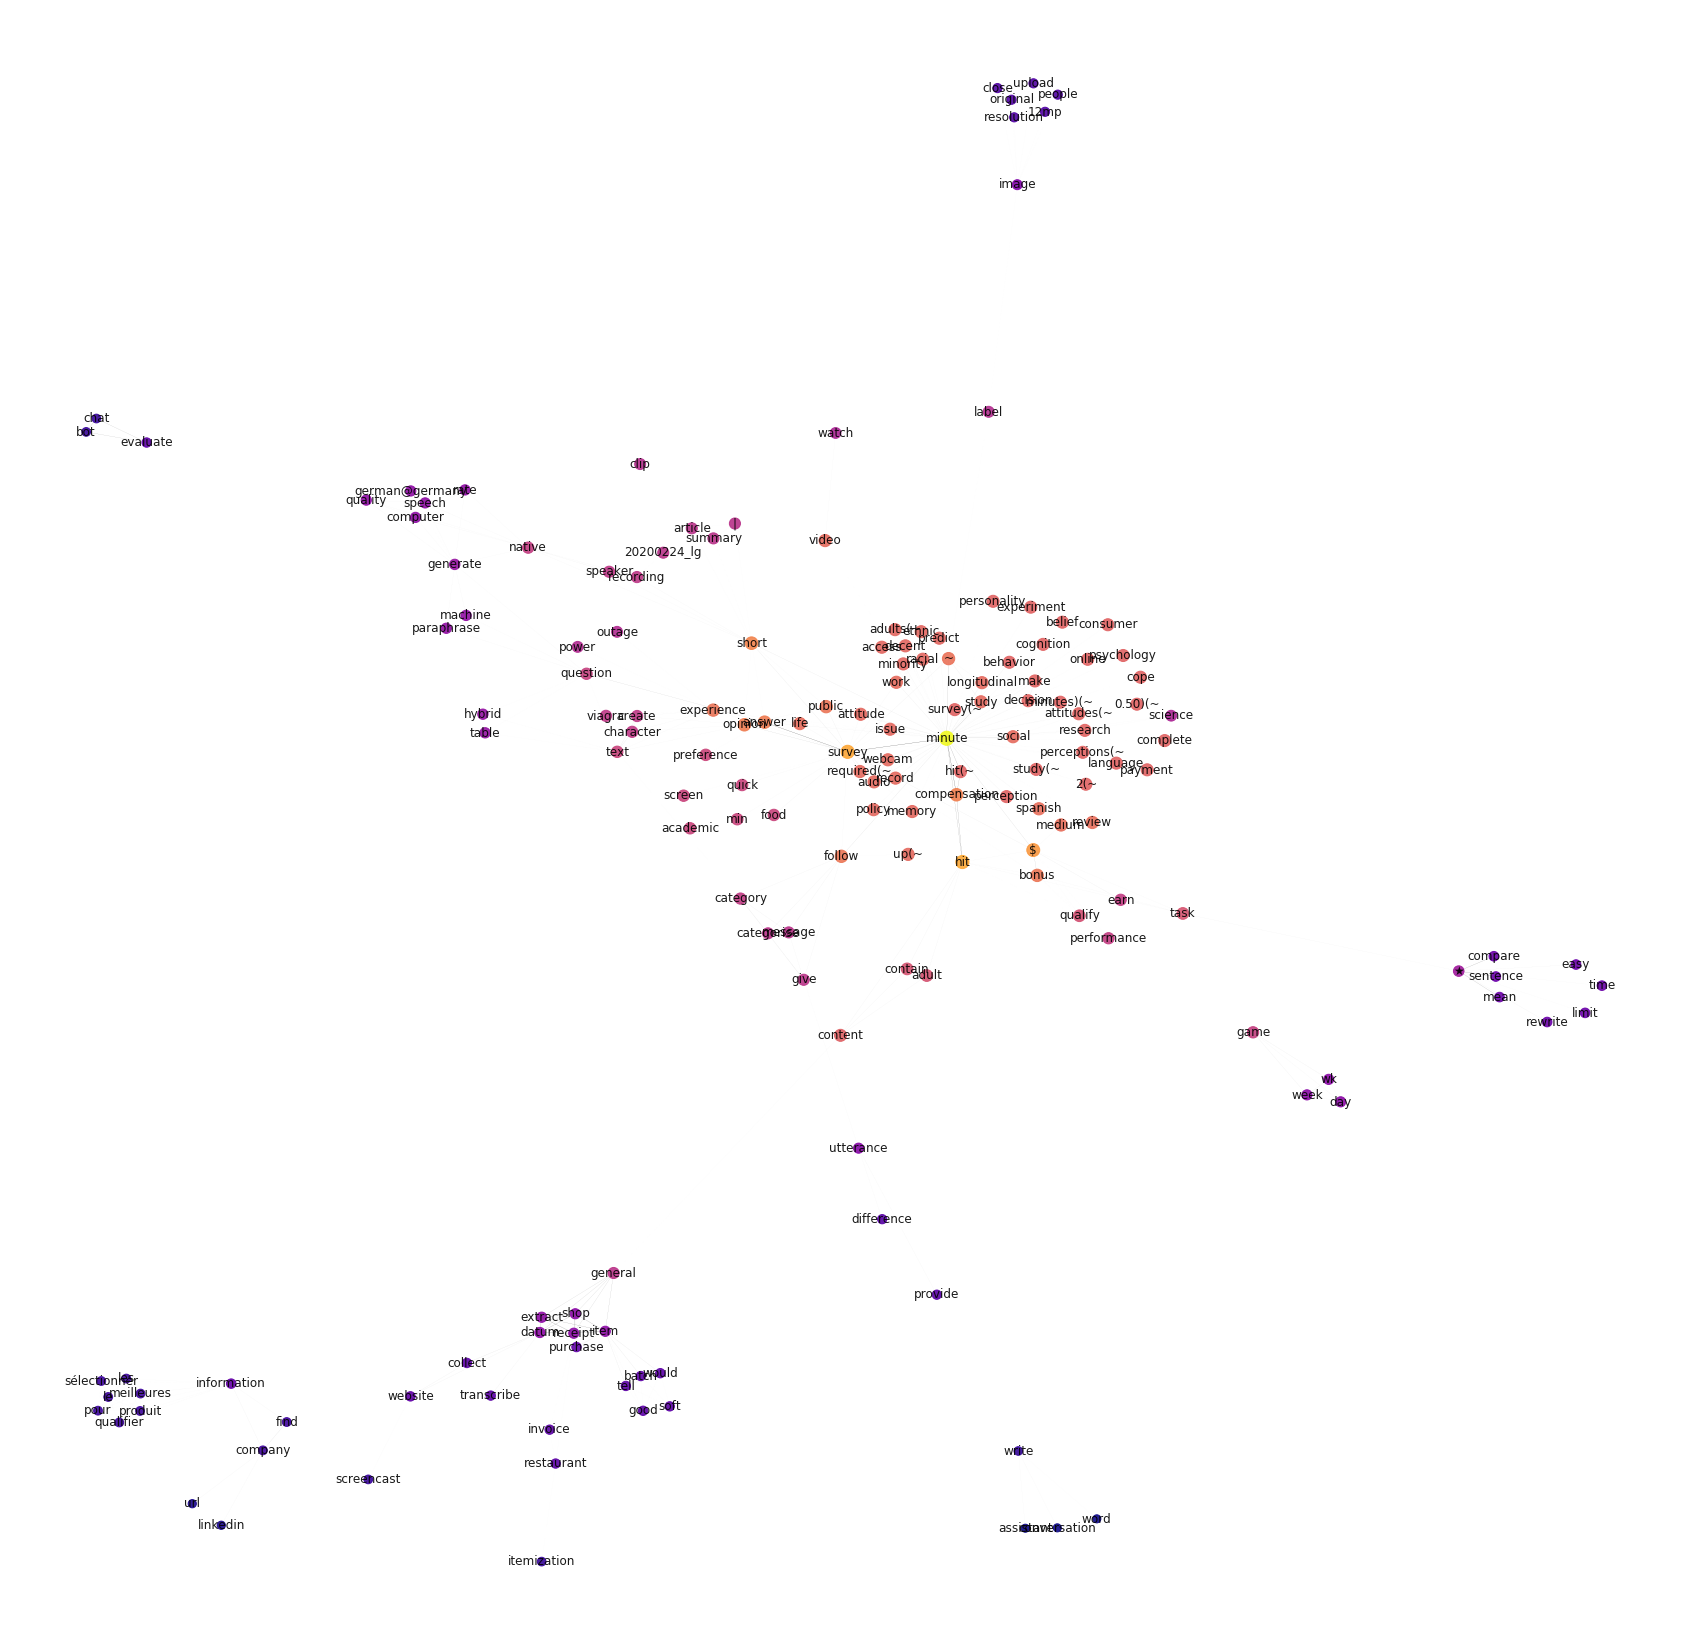

In [437]:
fig, ax = plt.subplots(figsize = (30,30))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        font_size = 12,
        font_color = "xkcd:black",
        edge_color='xkcd:black',
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

In [438]:
#Top
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('minute', 0.3755656108597285),
 ('hit', 0.32612966601178783),
 ('survey', 0.324853228962818),
 ('$', 0.3143939393939394),
 ('short', 0.2990990990990991),
 ('compensation', 0.29642857142857143),
 ('opinion', 0.29432624113475175),
 ('answer', 0.2938053097345133),
 ('follow', 0.28970331588132636),
 ('bonus', 0.289198606271777)]

In [439]:
#Bottom
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('screencast', 0.1438474870017331),
 ('bot', 0.14310344827586208),
 ('chat', 0.14310344827586208),
 ('itemization', 0.141396933560477),
 ('write', 0.14067796610169492),
 ('url', 0.12808641975308643),
 ('linkedin', 0.12808641975308643),
 ('conversation', 0.12351190476190477),
 ('assistant', 0.12351190476190477),
 ('word', 0.12342007434944238)]

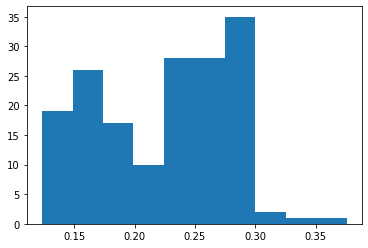

In [440]:
#plot
plt.hist(list(centralities.values()))
plt.show()

roughly binary distrubution

    Or eignvector centrality, an approach that weights degree by the centrality of those to whom one is tied (and the degree to whom they are tied, etc.) In short, its an  𝑛 th order degree measure.

In [441]:
#Eigenvector Centrality
centralities = nx.eigenvector_centrality(giant)

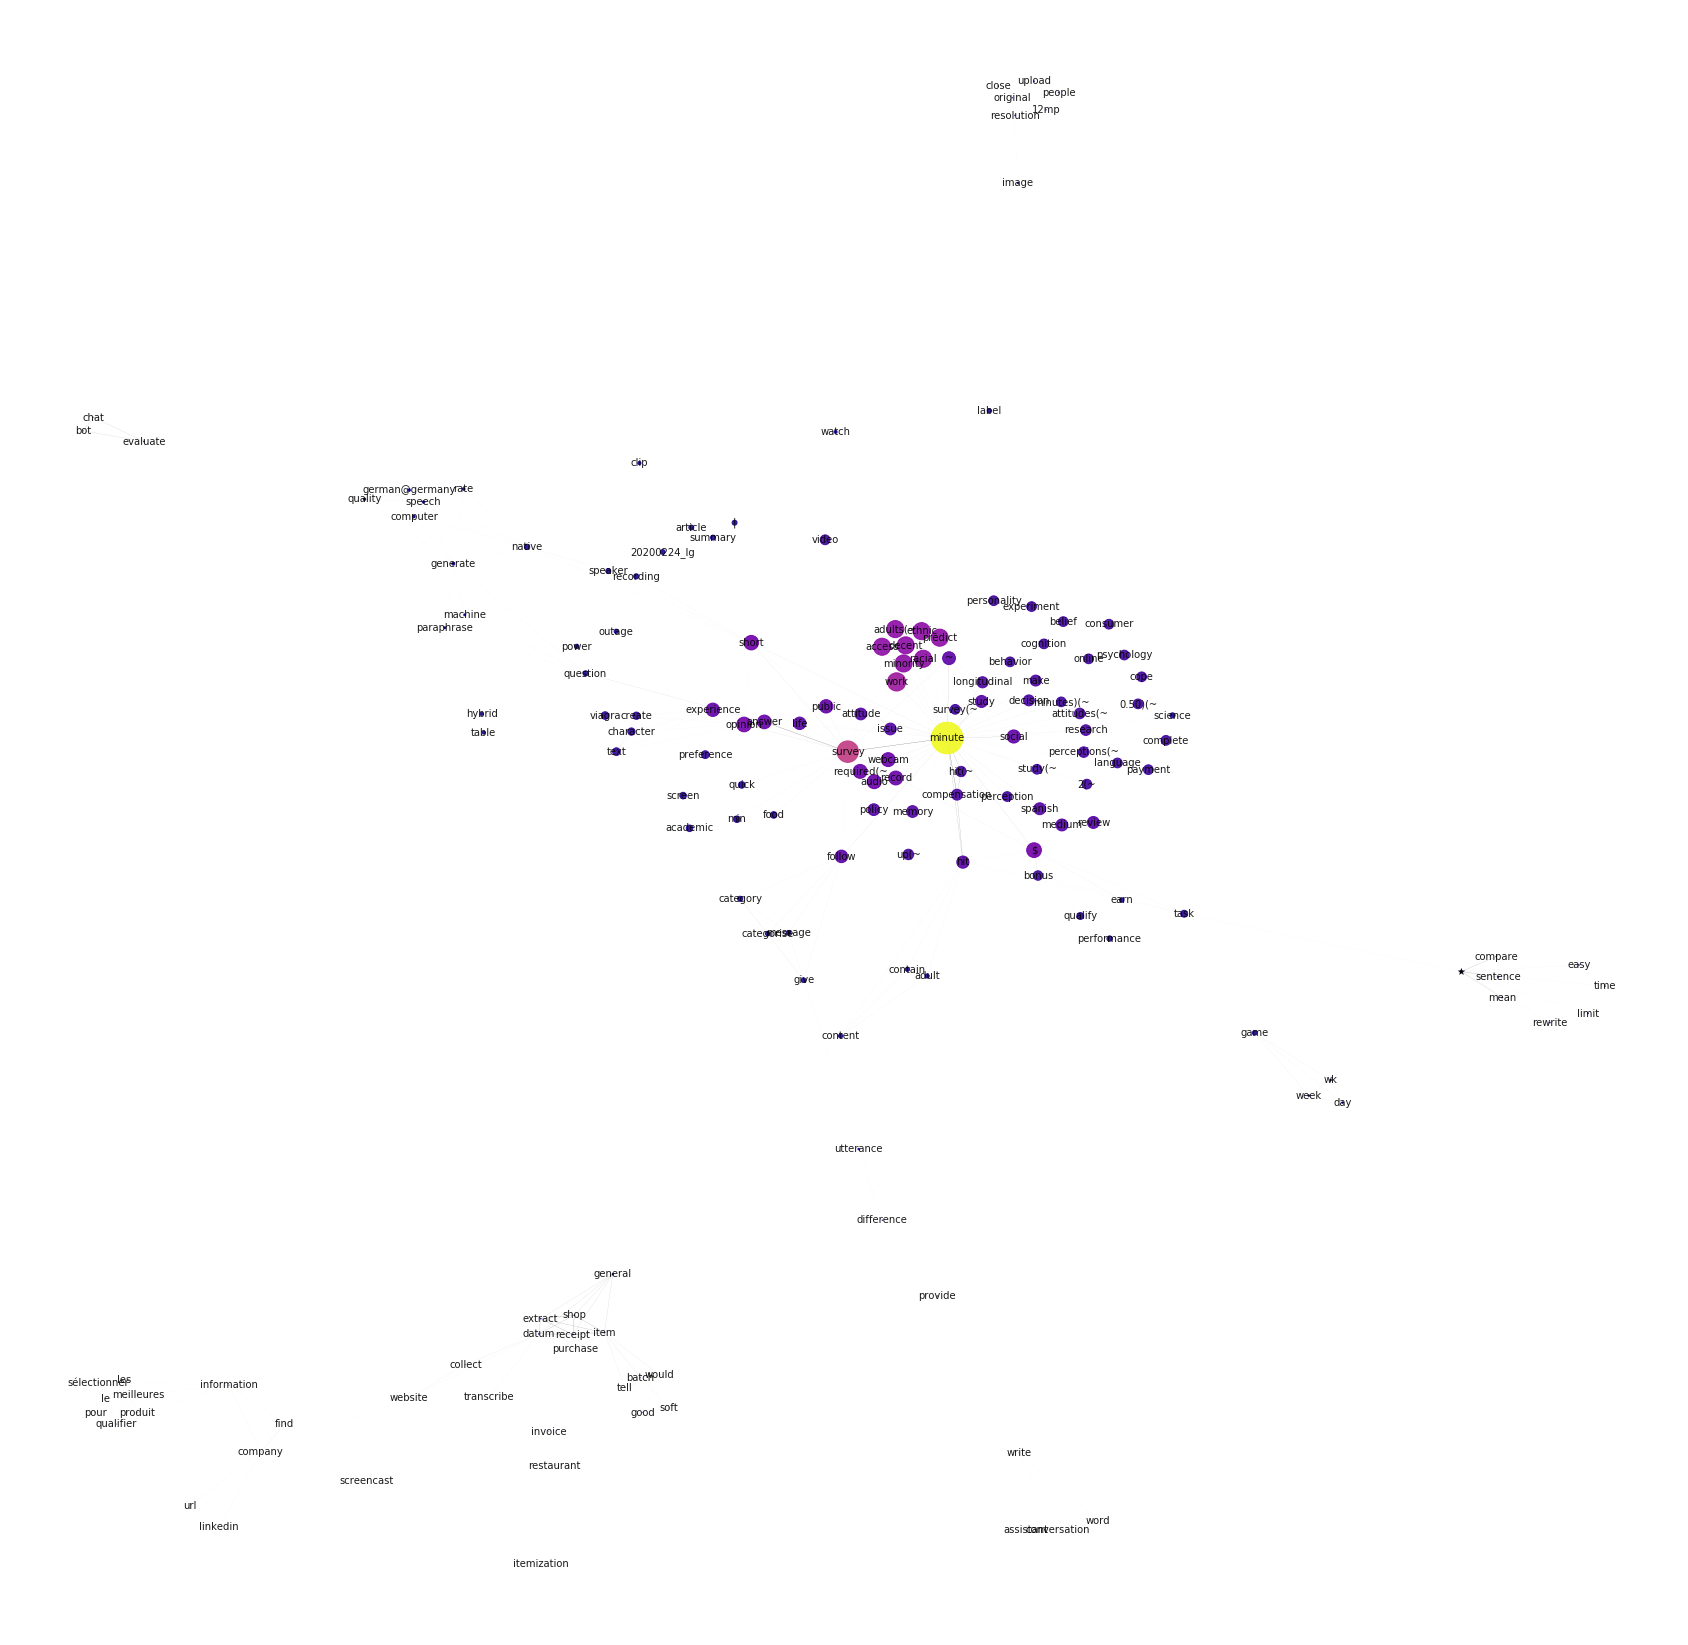

In [444]:
fig, ax = plt.subplots(figsize = (30,30))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        font_size = 10,
        font_color = "xkcd:black",
        edge_color='xkcd:black',
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 1000 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

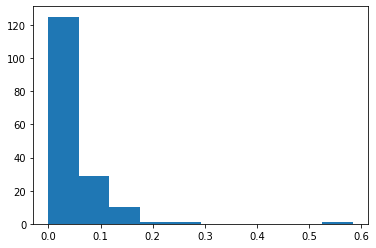

In [445]:
#graphing Eigenvector centrality
plt.hist(list(centralities.values()))
plt.show()

In [446]:
#top
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('minute', 0.5838837655188831),
 ('survey', 0.2690051387263887),
 ('work', 0.19395190117046834),
 ('minority', 0.17067608753001862),
 ('access', 0.17067608753001862),
 ('racial', 0.17067608753001862),
 ('predict', 0.17067608753001862),
 ('decent', 0.17067608753001862),
 ('ethnic', 0.17067608753001862),
 ('adults(~', 0.17067608753001862)]

besides the top 2, all these appear to be from a particular set of HITs on the subject of 'predicting adult racial/ethnic minorities' access to decent work' or similar.  this cohesive set has only appeared in the Eigenvector centrality metrics, implying that these HITs are uniquely tied to another concept/s that are very highly central.  

looking at the plot, this singular concept could be "[tilde symbol]" which is itself relatively central but more notably forms a bottleneck between the listed cluster and "minute", possibly because it is only associated with both some semantic element of the listed cluster and approximating time (e.g. "~5 mintues").  

In [447]:
#bottom
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('write', 1.2635215324514624e-05),
 ('company', 8.754119359076548e-06),
 ('find', 7.631938776903154e-06),
 ('screencast', 2.1006950046190466e-06),
 ('itemization', 1.9171738513999496e-06),
 ('conversation', 1.322107078809046e-06),
 ('assistant', 1.322107078809046e-06),
 ('word', 1.1968673597826212e-06),
 ('url', 1.0136326742023537e-06),
 ('linkedin', 1.0136326742023537e-06)]

In [233]:
## FILTERING NETWORK BY A CENTRALITY MEASURE ##

#defining a function
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [449]:
#betweenness
giant_filtered30 = filterWords(giant, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 43
Average degree:   3.4400


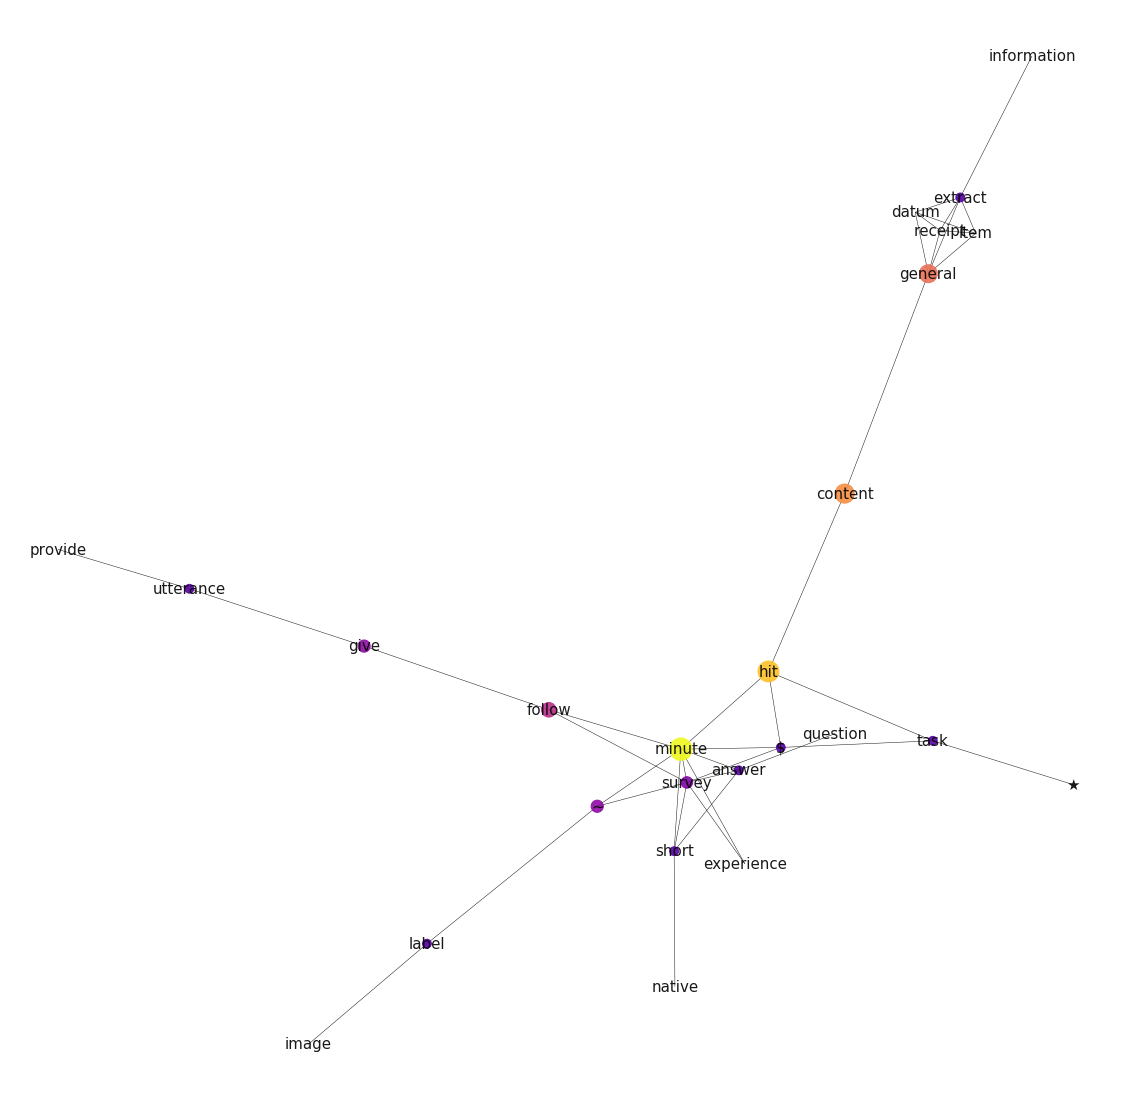

In [455]:
#betweennes
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (20,20))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 500 for n in giant_filtered30.nodes],
        font_size = 15,
        font_color = 'xkcd:black',
        edge_color = 'xkcd:black',
        cmap = plt.get_cmap('plasma'),
       )

In [456]:
#eigenvector
giant_filtered30 = filterWords(giant, minWeight=3, filter_='eigenvector', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 81
Average degree:   6.4800


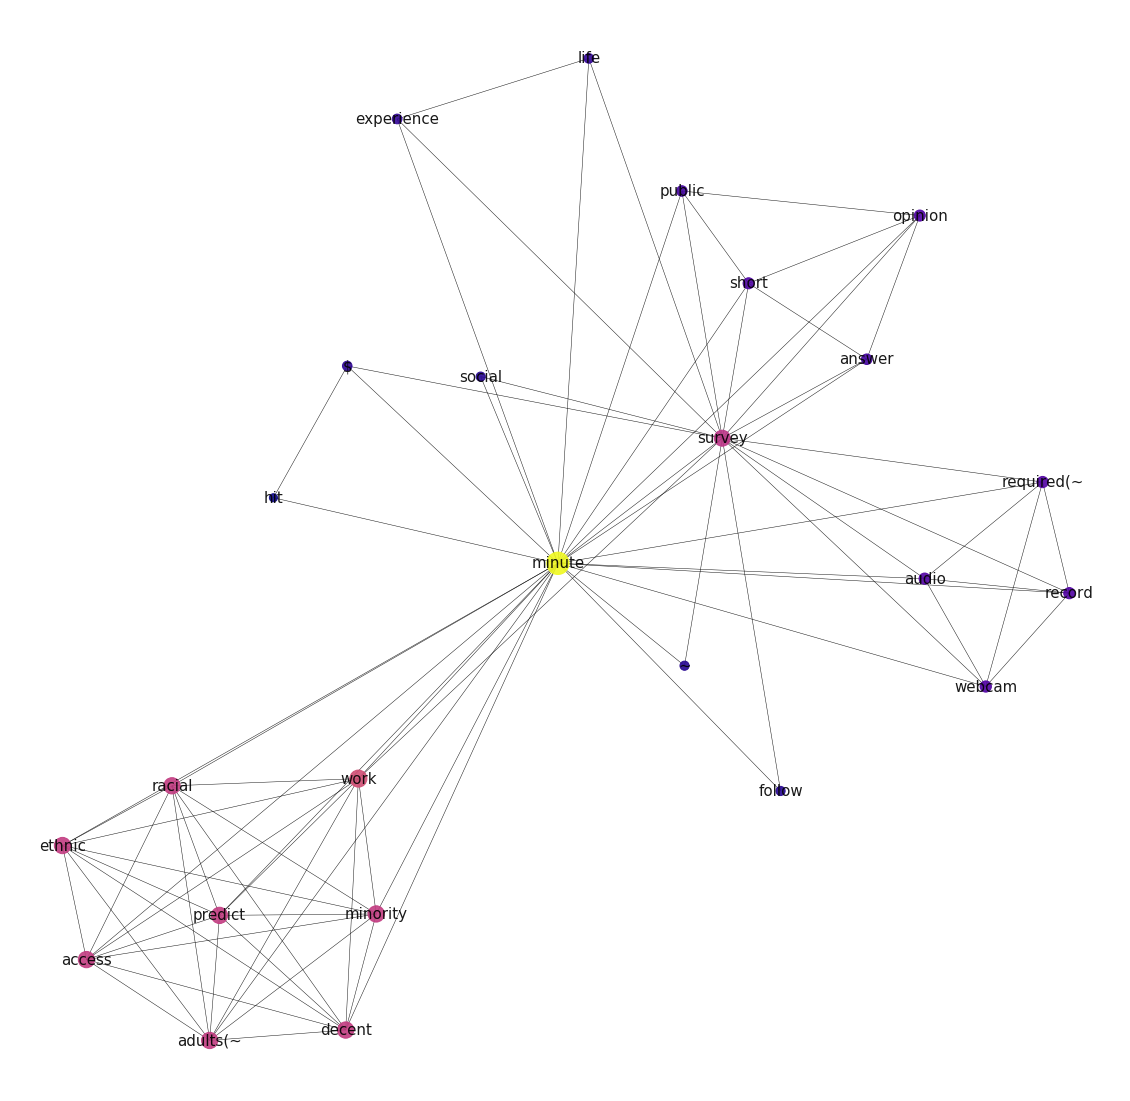

In [458]:
#eigenvector
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (20,20))
centralities_giant30 = nx.eigenvector_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 500 for n in giant_filtered30.nodes],
        font_size = 15,
        font_color = 'xkcd:black',
        edge_color = 'xkcd:black',
        cmap = plt.get_cmap('plasma'),
       )

having filtered the plot, it is clear now that the notable cluster from before is actually directly linked to "minute" and this is the source of its eigenvector centrality

### global statistics 

In [459]:
#Density (he number of actual edges divided by the total number of possible edges)
nx.density(giant)

0.027559339153019263

In [460]:
#Mean (average degree per node)
np.mean([v for w,v in nx.degree(giant)])

4.574850299401198

In [461]:
#Diamter (average distance between any two nodes in the network)
nx.diameter(giant)

13

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that construct at least two different networks comprising different combinations of word types, linked by different syntactic structures, which illuminate your corpus and the dynamics you are interested to explore. Graph these networks or subnetworks within them. What are relationships that are meaningful? 

<span style="color:red">***Stretch***: Graph some word-centered "ego-networks" with words one link away, two links away, and three links away (we only did up to two links away above).

# POS based networks

Now let's look at links between specific parts of speech within a network.



Let's look at nouns co-occurring in sentences using the top 10 (by score) reddit posts on thread topics we have explored in prior sessions:

In [2]:
### UPDATING Corpus1a.csv FILE AND DATAFRAME ###

#concattenating the csv files in the corpus
import glob
path = r'C:\Users\acmel\OneDrive - The University of Chicago\SOCI 40133\SOCI_FINAL\Corpus1a'
all_files = glob.iglob(os.path.join(path, "*.csv")) 
df = pd.concat((pd.read_csv(f).assign(filename = f.replace(path+'\\', "")) for f in all_files), ignore_index=True).drop_duplicates(keep='last')

#removing the $ signs from the Reward column
df['Reward'] = df['Reward'].map(lambda x: x.lstrip(r'd\$'))

#saving the corpus csv 
df.to_csv(r'C:\Users\acmel\OneDrive - The University of Chicago\SOCI 40133\SOCI_FINAL\Corpus1a.csv', index = 0)
df

Requester  \
0                    Yixin Nie   
1            Sharmishtha Gupta   
2                        Panel   
3                        Panel   
4                        Panel   
5                        Panel   
6                        Panel   
7                        Panel   
8                        Panel   
9                        TeamZ   
10                Ibotta, Inc.   
11                       TeamZ   
12                Ibotta, Inc.   
13                Rece Capture   
14           Shopping Receipts   
15                 Job Spotter   
16           Crowdsurf Support   
17                     Patrick   
18              James Billings   
19                     Foxtrot   
20                         p9r   
21             Panos Ipeirotis   
22                         p9r   
23                rich hoffman   
24                lovergingers   
25                lovergingers   
26                     Dorothy   
27                         p9r   
28           Crowdsurf Support   
29                       Panel   
...                        ...   
53845            Olivier Klein   
53846            Olivier Klein   
53847                 PPC WWBP   
53848            Olivier Klein   
53849            Olivier Klein   
53850            Olivier Klein   
53851            Olivier Klein   
53852                     LSAN   
53853                Noah Turk   
53854                Noah Turk   
53855            Olivier Klein   
53856                Noah Turk   
53857        Dialogue Research   
53858                Noah Turk   
53859  Chatbot for Car Dealers   
53860  Chatbot for Car Dealers   
53861  Chatbot for Car Dealers   
53862              Paul Conway   
53863                L. Martin   
53864             Jasmine Wang   
53865             Jasmine Wang   
53866            Joanna Herres   
53867            Darren Thorpe   
53868                Pinterest   
53869                Pinterest   
53870                     LSAN   
53871                 Clic2Buy   
53872                 Clic2Buy   
53873                 Clic2Buy   
53874                 Clic2Buy   

                                                   Title   HITs Reward  \
0                               Inference from the Text!     76   0.12   
1      Watch TV clips and see if it's changing to/fro...      2   0.05   
2      Extract purchased items from a shopping receip...    175   0.01   
3        Extract purchased items from a shopping receipt  3,327   0.08   
4      Extract purchased items from a shopping receip...     99   0.01   
5      Extract summary information from 24 shopping r...     18   0.05   
6        Extract purchased items from a shopping receipt     25   0.08   
7        Extract purchased items from a shopping receipt      2   0.09   
8      Extract purchased items from a shopping receip...      1   0.06   
9      Restaurant Receipt/Invoice with Bonus -- ITEMI...  1,401   0.08   
10                          Are these receipts the same?      3   0.01   
11     Restaurant Receipt/Invoice with Bonus -- ITEMI...     14   0.04   
12                          Are these receipts the same?      1   0.01   
13                                 Receipt Transcription    195   0.03   
14                    Extract Data From Shopping Receipt  1,325   0.01   
15     Collect store information of a hiring sign (WA...      1   0.06   
16         QC Reject - Earn up to $0.20 per media minute      2   0.20   
17     Answer a survey about your opinions, Best-in-C...      1   0.05   
18                                Market Research Survey  9,750   0.01   
19                                Copy Edit English Text      1   0.05   
20                                       Transcribe data      1   0.07   
21                                   Demographics survey      1   0.10   
22                                       Transcribe data      5   0.01   
23     Do these profile photos contain a real human f...      2   0.02   
24          ★★Rewrite★★Sentences★★#★#!★!10X★★bonus!★!#★#    11

In [86]:
### CREATING topRewards DATAFRAME ###

#converting decimals into floats to be sorted properly
df.Reward = df.Reward.astype(float)

#top 500 highest-paying HITs
topRewards = df.sort_values('Reward')[-1000:]
topRewards['sentences'] = topRewards['Title'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
topRewards['normalized_sents'] = topRewards['sentences'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])
topRewards.index = range(len(topRewards) - 1, -1,-1) #Reindex to make things nice in the future
topRewards

Requester  \
999                   Olivier Klein   
998                   Olivier Klein   
997                   Olivier Klein   
996                   Olivier Klein   
995                CPU at Mt. Sinai   
994                     SurveyComet   
993                     SurveyComet   
992                     SurveyComet   
991                   Olivier Klein   
990                   Olivier Klein   
989                CPU at Mt. Sinai   
988                   Olivier Klein   
987                     SurveyComet   
986                CPU at Mt. Sinai   
985                CPU at Mt. Sinai   
984                   Olivier Klein   
983                   Olivier Klein   
982                   Olivier Klein   
981                   Olivier Klein   
980                   Olivier Klein   
979                CPU at Mt. Sinai   
978                CPU at Mt. Sinai   
977                   Olivier Klein   
976                     SurveyComet   
975                     SurveyComet   
974                   Olivier Klein   
973                     SurveyComet   
972                     SurveyComet   
971                CPU at Mt. Sinai   
970                     SurveyComet   
..                              ...   
29             Acme Data Collection   
28             Acme Data Collection   
27             Acme Data Collection   
26             Acme Data Collection   
25             Acme Data Collection   
24             Acme Data Collection   
23                              Rex   
22             Acme Data Collection   
21             Acme Data Collection   
20   AB Lab - University of Calgary   
19             Acme Data Collection   
18                  Hyeon mook-Park   
17                  Hyeon mook-Park   
16             Acme Data Collection   
15             Acme Data Collection   
14             Acme Data Collection   
13             Acme Data Collection   
12             Acme Data Collection   
11                  Hyeon mook-Park   
10             Acme Data Collection   
9              Acme Data Collection   
8              Acme Data Collection   
7              Acme Data Collection   
6                          ShengZhi   
5                          ShengZhi   
4                          ShengZhi   
3                          ShengZhi   
2                          ShengZhi   
1                          ShengZhi   
0                          ShengZhi   

                                                 Title HITs  Reward  \
999                             HIT for A1U5BE8XJRXKW3    1     8.0   
998                             HIT for A1U5BE8XJRXKW3    1     8.0   
997                             HIT for A1U3UUELW55W65    1     8.0   
996                             HIT for A1U3UUELW55W65    1     8.0   
995                     Economic Decision Making Study    1     8.0   
994  Survey - webcam & audio recording required(~ 2...   22     8.0   
993  Survey - webcam & audio recording required(~ 2...   22     8.0   
992  Survey - webcam & audio recording required(~ 2...   22     8.0   
991                             HIT for A1U5BE8XJRXKW3    1     8.0   
990                             HIT for A1U5BE8XJRXKW3    1     8.0   
989                     Economic Decision Making Study    1     8.0   
988                             HIT for A1U3UUELW55W65    1     8.0   
987  Survey - webcam & audio recording required(~ 2...   22     8.0   
986                     Economic Decision Making Study    1     8.0   
985                     Economic Decision Making Study    1     8.0   
984                             HIT for A1U5BE8XJRXKW3    1     8.0   
983                             HIT for A1U5BE8XJRXKW3    1     8.0   
982                             HIT for A1U5BE8XJRXKW3    1     8.0   
981                             HIT for A1U5BE8XJRXKW3    1     8.0   
980                             HIT for A1U3UUELW55W65    1     8.0   
979                     Economic Decision Making Study    1     8.0   
978                     Economic Decision Mak

In [87]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [88]:
#defining the POS co-occurance function
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [122]:
#Noun Coocurrences 
gNN = posCooccurrence(topRewards['normalized_sents'].sum(), 'NN')
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 33
Number of edges: 38
Average degree:   2.3030


In [123]:
#removing vertices with degree less than or equal to 1
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 2]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 10
Number of edges: 17
Average degree:   3.4000


In [124]:
#removing low weight edges
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 0.2])
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 10
Number of edges: 17
Average degree:   3.4000


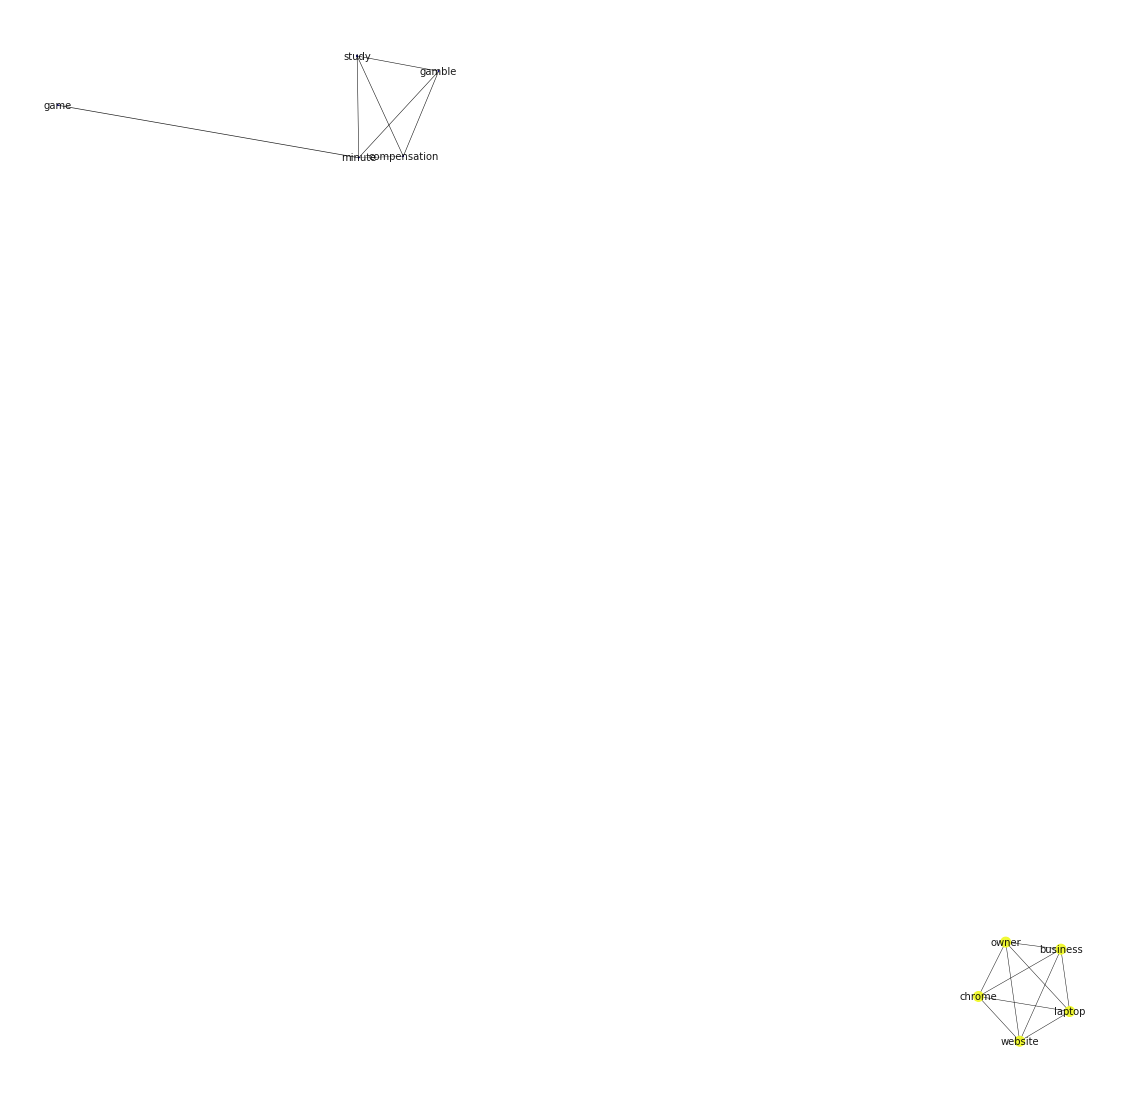

In [131]:
#visualizing NN cooccurances (eigenvector)

#layout_nn = nx.spectral_layout(gNN, weight='weight') #,iterations= 100)
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (20,20))
#NOTE: must use "_numpy" to prevent a NewtorkxError 
#due to having 2 equal-sized Eigenvalues
centralities_nn = nx.eigenvector_centrality_numpy(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight']*50 for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 10,
        font_color = 'xkcd:black',
        edge_color = 'xkcd:black',
        cmap = plt.get_cmap('plasma'),
       )

the two fully or nearly-fully interconnected clusters in this visualization are highly distant from eachother and any outliers, and represent the only eigenvector associations therein.  additionally, the one of the two that is perfectly interconnected is also the only cluster with visibly large nodes.  

the words in this cluster suggest a HIT requiring google chrome + a laptop and involving a website to do with businesses and their owners, or perhaps requring the worker to be a business owner themself.

In [186]:
#Noun-Verb Pair Cooccurrences
gNV = posCooccurrence(topRewards['normalized_sents'].sum(), 'NN', 'VB')
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 39
Number of edges: 51
Average degree:   2.6154


In [187]:
#removing NN-NN and VB-VB cooccurences from gNV
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 39
Number of edges: 12
Average degree:   0.6154


#removing low weight eges and low degree vertices
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 0.05])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 0.5])
print(nx.info(gNV))

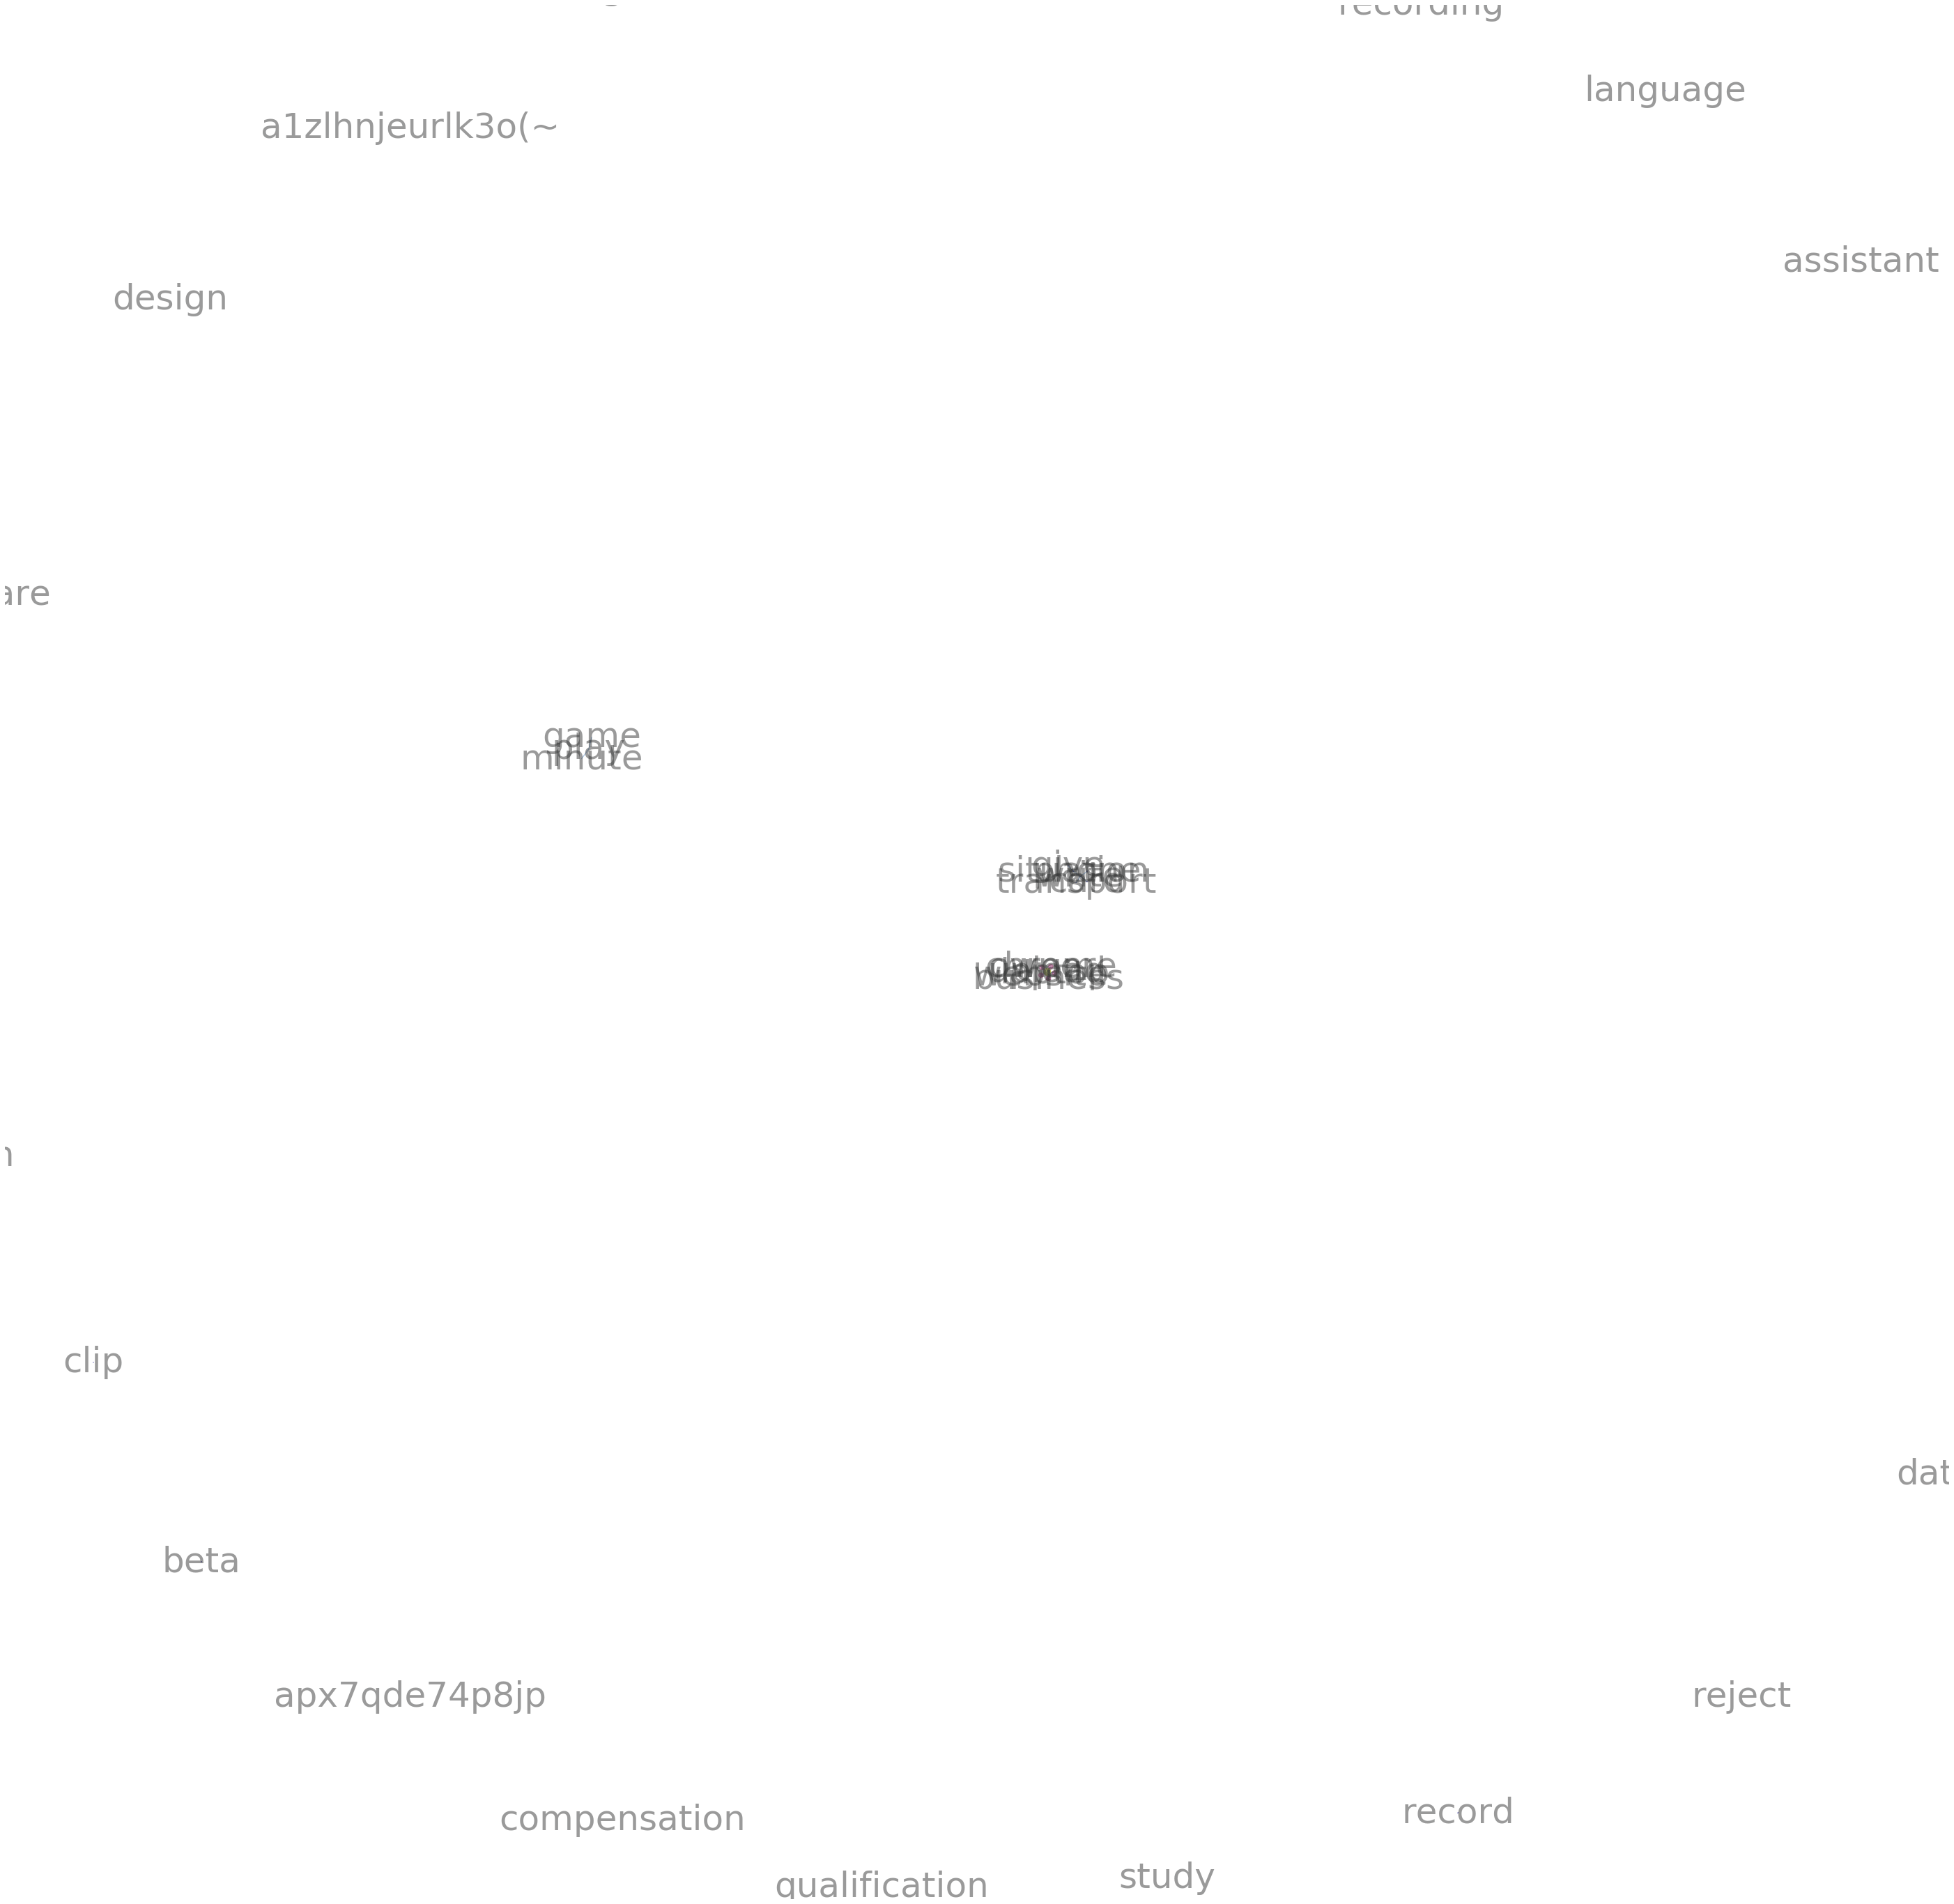

In [214]:
#visualizing NN-VB cooccurences (eigenvector)
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 300)
fig, ax = plt.subplots(figsize = (50,50))
centralities_nv = nx.eigenvector_centrality_numpy(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .5, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 50,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

In [217]:
list(gNV.nodes)

['game',
 'language',
 'upload',
 'access',
 'qualification',
 'cognition',
 'give',
 'effect',
 'card',
 'recording',
 'a1zlhnjeurlk3o(~',
 'situation',
 'study',
 'assistant',
 'transport',
 'business',
 'speaker',
 'gamble',
 'record',
 'reject',
 'minute',
 'design',
 'owner',
 'norm',
 'website',
 'write',
 'beta',
 'apx7qde74p8jp',
 'decision',
 'play',
 'phone',
 'chrome',
 'share',
 'collect',
 'video',
 'clip',
 'datum',
 'compensation',
 'laptop']

In [224]:
#creating a Ego Network around a single notable word
g_i = gNV.subgraph(['write'] + list(gNV.neighbors('write')))
print(nx.info(g_i))

Name: 
Type: Graph
Number of nodes: 5
Number of edges: 4
Average degree:   1.6000


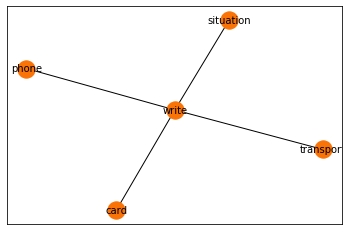

In [225]:
nx.draw_networkx(g_i, font_size=10, node_color="xkcd:orange")

In [226]:
#creating a "Neighbors" network around a vertex 
writeNeighbors = gNV.neighbors('write')
set(writeNeighbors)

{'card', 'phone', 'situation', 'transport'}

In [227]:
writeNeighbors = set(gNV.neighbors('write'))
writeNeighborsPlus1 = set(writeNeighbors)
for n in writeNeighbors:
    writeNeighborsPlus1 |= set(gNV.neighbors(n))
    
gNV_write = gNV.subgraph(writeNeighborsPlus1)
print(nx.info(gNV_write))

Name: 
Type: Graph
Number of nodes: 6
Number of edges: 5
Average degree:   1.6667


#### Network Statistics

In [228]:
#Degree Centrality
sorted(nx.degree_centrality(gNV_write).items(), key = lambda x: x[1], reverse = True)#[:10]

[('write', 0.8),
 ('situation', 0.4),
 ('phone', 0.2),
 ('transport', 0.2),
 ('give', 0.2),
 ('card', 0.2)]

In [229]:
#Eigenvector Centrality
sorted(nx.eigenvector_centrality(gNV_write).items(), key = lambda x: x[1], reverse = True)#[:10]

[('write', 0.6767657319837914),
 ('situation', 0.42504554868198824),
 ('phone', 0.32625975412584113),
 ('transport', 0.32625975412584113),
 ('card', 0.32625975412584113),
 ('give', 0.20491008777341216)]

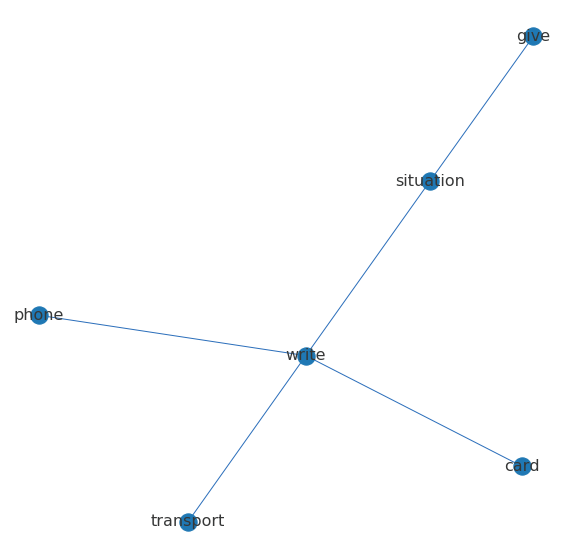

In [230]:
#visualizing "Neighbors" network
layout_write = nx.spring_layout(gNV_write, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_write, ax = ax, pos = layout_write, labels = {n: n for n in gNV_write.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

In [263]:
#creating a Noun-Adjective (NN-JJ) cooccurence network
gNJ = posCooccurrence(topRewards['normalized_sents'][:1000].sum(), 'NN', 'JJ')
print(nx.info(gNJ))

Name: 
Type: Graph
Number of nodes: 47
Number of edges: 82
Average degree:   3.4894


In [264]:
#filtering by a centrality measure to achieve a more "central" set of nodes
#instead of the most connected
gNJ_filtered200 = filterWords(gNJ, minWeight=3, filter_='betweenness', rule='number', value_of_rule=15)
print(nx.info(gNJ_filtered200))

Total number of nodes(after filtering) in the graph is 15
Name: 
Type: Graph
Number of nodes: 15
Number of edges: 21
Average degree:   2.8000


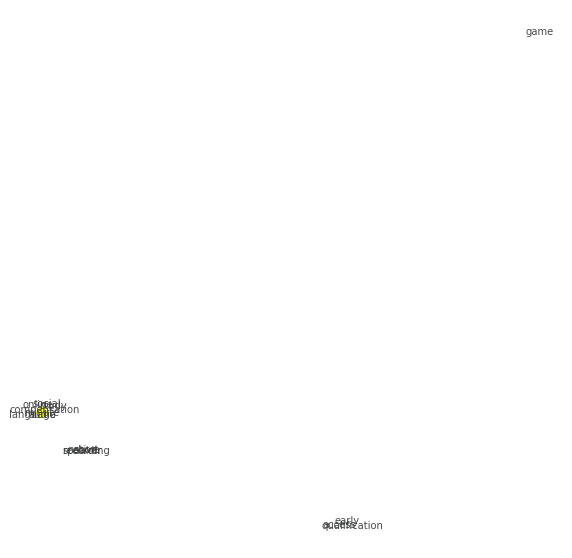

In [265]:
#visualizing NN-JJ cooccurence network
layout_NJ_filtered200 = nx.spring_layout(gNJ_filtered200, weight='weight', iterations= 200)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_filtered200.nodes()},
        alpha = .9, 
        width = .1,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200.nodes],
        font_size = 10,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that perform a similar social similarity or influence analysis on a dataset relevant to your final project. Create relationships between actors in a network based on your dataset (e.g., person to person or document to document), and perform analyses that interrogate the structure of their interactions, similarity, and/or influence on one another. (For example, if relevant to your final project, you could explore different soap operas, counting how many times a character may have used the word love in conversation with another character, and identify if characters in love speak like each other. Or do opposites attract?) What does that analysis and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

<span style="color:red">Stretch 1:
Render the social network with weights (e.g., based on the number of scenes in which actors appear together), then calculate the most central actors in the show.Realtime output can be viewed in shell.

<span style="color:red">Stretch 2:
Implement more complex measures of similarity based on the papers you have read.

    ## Creating networks of agents from corpora

    Now that we have an idea of how we can use networks in python (a useful skill to know!), let us see how we can now use our knowledge of networks on extracting actors from corpora and building relations from them. Let us use the soap opera corpus now. 

    In the last notebook we wrote methods to load corpora - this has been added to lucem_illud_2020.
    The code returns a dictionary with each id mapping to the text associated with it. 

    We would then use the source file to create the dataframe with the data - since this varies for each corpora, there is no built in function, but would follow a similar process.

    This function might take some time.

In [17]:
import pandas as pd

In [18]:
### UPDATING Corpus1a.csv FILE AND DATAFRAME ###

#concattenating the csv files in the corpus
import glob
path = r'C:\Users\acmel\OneDrive - The University of Chicago\SOCI 40133\SOCI_FINAL\Corpus1a'
all_files = glob.iglob(os.path.join(path, "*.csv")) 
df = pd.concat((pd.read_csv(f).assign(filename = f.replace(path+'\\', "")) for f in all_files), ignore_index=True).drop_duplicates(keep='last')

#removing the $ signs from the Reward column
df['Reward'] = df['Reward'].map(lambda x: x.lstrip(r'd\$'))

#saving the corpus csv 
df.to_csv(r'C:\Users\acmel\OneDrive - The University of Chicago\SOCI 40133\SOCI_FINAL\Corpus1a.csv', index = 0)
df

Requester  \
0                    Yixin Nie   
1            Sharmishtha Gupta   
2                        Panel   
3                        Panel   
4                        Panel   
5                        Panel   
6                        Panel   
7                        Panel   
8                        Panel   
9                        TeamZ   
10                Ibotta, Inc.   
11                       TeamZ   
12                Ibotta, Inc.   
13                Rece Capture   
14           Shopping Receipts   
15                 Job Spotter   
16           Crowdsurf Support   
17                     Patrick   
18              James Billings   
19                     Foxtrot   
20                         p9r   
21             Panos Ipeirotis   
22                         p9r   
23                rich hoffman   
24                lovergingers   
25                lovergingers   
26                     Dorothy   
27                         p9r   
28           Crowdsurf Support   
29                       Panel   
...                        ...   
54494            Olivier Klein   
54495            Olivier Klein   
54496                 PPC WWBP   
54497            Olivier Klein   
54498            Olivier Klein   
54499            Olivier Klein   
54500            Olivier Klein   
54501                     LSAN   
54502                Noah Turk   
54503                Noah Turk   
54504            Olivier Klein   
54505                Noah Turk   
54506        Dialogue Research   
54507                Noah Turk   
54508  Chatbot for Car Dealers   
54509  Chatbot for Car Dealers   
54510  Chatbot for Car Dealers   
54511              Paul Conway   
54512                L. Martin   
54513             Jasmine Wang   
54514             Jasmine Wang   
54515            Joanna Herres   
54516            Darren Thorpe   
54517                Pinterest   
54518                Pinterest   
54519                     LSAN   
54520                 Clic2Buy   
54521                 Clic2Buy   
54522                 Clic2Buy   
54523                 Clic2Buy   

                                                   Title   HITs Reward  \
0                               Inference from the Text!     76   0.12   
1      Watch TV clips and see if it's changing to/fro...      2   0.05   
2      Extract purchased items from a shopping receip...    175   0.01   
3        Extract purchased items from a shopping receipt  3,327   0.08   
4      Extract purchased items from a shopping receip...     99   0.01   
5      Extract summary information from 24 shopping r...     18   0.05   
6        Extract purchased items from a shopping receipt     25   0.08   
7        Extract purchased items from a shopping receipt      2   0.09   
8      Extract purchased items from a shopping receip...      1   0.06   
9      Restaurant Receipt/Invoice with Bonus -- ITEMI...  1,401   0.08   
10                          Are these receipts the same?      3   0.01   
11     Restaurant Receipt/Invoice with Bonus -- ITEMI...     14   0.04   
12                          Are these receipts the same?      1   0.01   
13                                 Receipt Transcription    195   0.03   
14                    Extract Data From Shopping Receipt  1,325   0.01   
15     Collect store information of a hiring sign (WA...      1   0.06   
16         QC Reject - Earn up to $0.20 per media minute      2   0.20   
17     Answer a survey about your opinions, Best-in-C...      1   0.05   
18                                Market Research Survey  9,750   0.01   
19                                Copy Edit English Text      1   0.05   
20                                       Transcribe data      1   0.07   
21                                   Demographics survey      1   0.10   
22                                       Transcribe data      5   0.01   
23     Do these profile photos contain a real human f...      2   0.02   
24          ★★Rewrite★★Sentences★★#★#!★!10X★★bonus!★!#★#    11

In [35]:
dfa = df[:100]
dfa

Requester  \
0                             Yixin Nie   
1                     Sharmishtha Gupta   
2                                 Panel   
3                                 Panel   
4                                 Panel   
5                                 Panel   
6                                 Panel   
7                                 Panel   
8                                 Panel   
9                                 TeamZ   
10                         Ibotta, Inc.   
11                                TeamZ   
12                         Ibotta, Inc.   
13                         Rece Capture   
14                    Shopping Receipts   
15                          Job Spotter   
16                    Crowdsurf Support   
17                              Patrick   
18                       James Billings   
19                              Foxtrot   
20                                  p9r   
21                      Panos Ipeirotis   
22                                  p9r   
23                         rich hoffman   
24                         lovergingers   
25                         lovergingers   
26                              Dorothy   
27                                  p9r   
28                    Crowdsurf Support   
29                                Panel   
..                                  ...   
70                          Scotty Alto   
71                                Khanh   
72                                henry   
73                                TeamZ   
74                         Bright--Side   
75                            Wang Liao   
76                              BIU NLP   
77                            Wang Liao   
78                              UserBob   
79  SoundingBox (Change Sciences Group)   
80                                 HUGC   
81                           Faizan Ali   
82                          IC3 AI team   
83                              stephen   
84                              Jungmin   
85                      Sauder Research   
86                                TeamZ   
87                                 HUGC   
88                                 Xzzx   
89                  BoxWave Corporation   
90                              Positly   
91                           WenTing Li   
92                              Cardcow   
93                              Cardcow   
94                              Cardcow   
95                    Crowdsurf Support   
96                       quarrel-recast   
97                                 Sean   
98                          Scotty Alto   
99                                 HUGC   

                                                Title   HITs Reward  \
0                            Inference from the Text!     76   0.12   
1   Watch TV clips and see if it's changing to/fro...      2   0.05   
2                                                 NaN    175   0.01   
3                                                 NaN  3,327   0.08   
4                                                 NaN     99   0.01   
5                                                 NaN     18   0.05   
6                                                 NaN     25   0.08   
7                                                 NaN      2   0.09   
8                                                 NaN      1   0.06   
9                                                 NaN  1,401   0.08   
10                                                NaN      3   0.01   
11                                                NaN     14   0.04   
12  Are these receipts the same? | Are these recei...      1   0.01   
13                              Receipt Transcription    195   0.03   
14                 Extract Data From Shopping Receipt  1,325   0.01   
15  Collect store information of a hiring sign (WA...      1   0.06   
16                                                NaN      2   0.20   
17  Answer a survey about your opinions, Best-in-C...      1   0.05   
18            

In [37]:
#concattenating all Title texts from all HITs by unique Requesters 
dfa['Title'] = dfa[['Requester','Title']].groupby(['Requester'])['Title'].transform(lambda x: ' | '.join(x))
dfa[['Requester','Title']].drop_duplicates(keep='last')
dfa

TypeError: sequence item 0: expected str instance, float found

In [16]:
#defining word_tokenize
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [19]:
import lucem_illud_2020
from lucem_illud_2020 import word_tokenize

#### DATAFRAME tokenizing+normalizing AND SAVING to csv ###

#tokenizing+normalizing sentences
#dfa['tokenized_texts'] = dfa['Concat_Titles'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.word_tokenize(x)])
#dfa['normalized_texts'] = dfa['tokenized_texts'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])
dfa['tokenized_texts'] = dfa['Concat_Titles'].apply(lambda x: word_tokenize(x))

#saving the tokenized+normalized corpus csv
#df.to_csv(r'C:\Users\acmel\OneDrive - The University of Chicago\SOCI 40133\SOCI_FINAL\Corpus1a_TkNmSents.csv', index = False)
dfa

Requester  \
0                        Yixin Nie   
1                Sharmishtha Gupta   
2                            Panel   
3                            Panel   
4                            Panel   
5                            Panel   
6                            Panel   
7                            Panel   
8                            Panel   
9                            TeamZ   
10                    Ibotta, Inc.   
11                           TeamZ   
12                    Ibotta, Inc.   
13                    Rece Capture   
14               Shopping Receipts   
15                     Job Spotter   
16               Crowdsurf Support   
17                         Patrick   
18                  James Billings   
19                         Foxtrot   
20                             p9r   
21                 Panos Ipeirotis   
22                             p9r   
23                    rich hoffman   
24                    lovergingers   
25                    lovergingers   
26                         Dorothy   
27                             p9r   
28               Crowdsurf Support   
29                           Panel   
30                    Peggy Keller   
31                         zhou yu   
32                   CopyText Inc.   
33                   Tracy Worrell   
34               Crowdsurf Support   
35          Ignite Media Solutions   
36          Ignite Media Solutions   
37                             p9r   
38                             p9r   
39                     Bill Xouris   
40                           TeamZ   
41                     FullContact   
42  Social Perception Research Lab   
43                          PickFu   
44                    lovergingers   
45                       SocialCat   
46                             p9r   
47                            HUGC   
48                         Melissa   
49                            HUGC   

                                                Title   HITs Reward  \
0                            Inference from the Text!     76   0.12   
1   Watch TV clips and see if it's changing to/fro...      2   0.05   
2   Extract purchased items from a shopping receip...    175   0.01   
3     Extract purchased items from a shopping receipt  3,327   0.08   
4   Extract purchased items from a shopping receip...     99   0.01   
5   Extract summary information from 24 shopping r...     18   0.05   
6     Extract purchased items from a shopping receipt     25   0.08   
7     Extract purchased items from a shopping receipt      2   0.09   
8   Extract purchased items from a shopping receip...      1   0.06   
9   Restaurant Receipt/Invoice with Bonus -- ITEMI...  1,401   0.08   
10                       Are these receipts the same?      3   0.01   
11  Restaurant Receipt/Invoice with Bonus -- ITEMI...     14   0.04   
12                       Are these receipts the same?      1   0.01   
13                              Receipt Transcription    195   0.03   
14                 Extract Data From Shopping Receipt  1,325   0.01   
15  Collect store information of a hiring sign (WA...      1   0.06   
16      QC Reject - Earn up to $0.20 per media minute      2   0.20   
17  Answer a survey about your opinions, Best-in-C...      1   0.05   
18                             Market Research Survey  9,750   0.01   
19                             Copy Edit English Text      1   0.05   
20                                    Transcribe data      1   0.07   
21                                Demographics survey      1   0.10   
22                                    Transcribe data      5   0.01   
23  Do these profile photos contain a real human f...      2   0.02   
24       ★★Rewrite★★Sentences★★#★#!★!10X★★bonus!★!#★#    111   0.01   
25  ★★★★★Compare Sentences by Meaning★★★★★Increase...     67   0.20   
26  Answer a survey about your opinions toward a n...      1   1.00   
27                                    Transcribe data      2   0.02   
28  Timing review - Earn up

# Interactional influence

In a recent paper by Fangjian Guo, Charles Blundell, Hanna Wallach, and Katherine Heller entitled ["The Bayesian Echo Chamber: Modeling Social Influence via Linguistic Accommodation"](https://arxiv.org/pdf/1411.2674.pdf), the authors develop a method to estimate the influence of one speaker on another in order to estimate a kind of interpersonal influence network. Here we walk through this method, which relies on a kind of point process called a Hawkes process that estimate the influence of one point on another. Specifically, what they estimate is the degree to which one actor to an interpersonal interaction engaged in "accomodation" behaviors relative to the other, generating a directed edge from the one to the other.

### First let's look at the output of their analysis:

### Plot MCMC (Markov Monte Carlo) trace and the density of log-likelihoods

### Plot the influence matrix between participants

### Barplot of total influences sent/received

Total influence:

## Visualize Influence Network!

You can visualize any of the influence matrices above:

Using networkx:

Your own dataset should contains 4 columns (with the same column names) as the artificial one below:

- name: name of the participant
- tokens: a list of tokens in one utterance
- start: starting time of utterance (unit doesn't matter, can be 'seconds','minutes','hours'...)
- end: ending time of utterance (same unit as start)

There is no need to sort data for the moment.

Below, we generate a fake collection of data from "Obama", "Trump", "Clinton"...and other recent presidents. You can either create your own simulation OR (better), add real interactional data from a online chat forum, comment chain, or transcribed from a conversation.

Transform data into TalkbankXML format:

Run Bayesian Echo Chamber to get estimation.

- It may take a couple of hours. ( About 4-5 hours if Vocab_size=600 and sampling_time =2000)
- Larger "Vocab_size" (see below) will cost more time
- Larger "sampling_time" will also consume more time